# dependencies
* install anaconda is recommended

```
cassandra-driver          3.11.0                   py35_1    conda-forge
pandas                    0.19.1              np111py35_0
scikit-learn              0.18.1              np111py35_0
scipy                     0.18.1              np111py35_0
matplotlib                2.0.0               np111py35_0
```

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib
import time
import numpy as np
%matplotlib inline

import pandas as pd
pd.options.display.max_colwidth = 300
pd.options.display.max_columns = 100

# import training as training

In [2]:
#Model File Directory
WORK_DIR = '/var/spark/ml_files/'

#Label Keys
LABEL = "success"

MODEL_TYPE = "ML-BR"

start_date = '2018-01-01'
end_date = '2018-10-31'
# site_ids = ['adbehap']
# site_ids = ['avast', 'kasperus', 'adbehap', 'adbehbr', 'adbehkr', 'mcafeeus', 'mfeap', 'mfeeu']
# desc = str('%s_%s_%s' % (start_date, end_date, "_".join(site_ids)))
# desc = '%s_%s_All_sites'.format(start_date, end_date)
desc = '%s_%s_last_two_att_num'.format(start_date, end_date)

In [3]:
# from cassandra
from cassandra.cluster import Cluster
# cassandra_endpoint = '10.62.1.118'
cassandra_endpoint = '10.224.12.32'
cluster = Cluster([cassandra_endpoint])
# session = cluster.connect('subs')


In [48]:
df_cs_original['site_id'].value_counts()

avast       3368772
adbehap     1543648
kasperus    1118450
adbehkr      649196
adbehbr      605376
mfeeu        112575
mfeap         17979
mcafeeus        116
Name: site_id, dtype: int64

In [27]:
# retry_success =  pd.read_csv('/drhdev/workspace/ml/pdf_all_site_2018-05-01_2018-05-31_pro_att.csv')
# retry_success =  pd.read_csv('/drhdev/workspace/ml/pdf_all_site_2018-01-01_2018-03-31_pro_att.csv')
# retry_success =  pd.read_csv(WORK_DIR + 'retry_success_01_to_10.csv')  #(10761324, 54)
retry_success =  pd.read_csv(WORK_DIR + 'retry_success_last_two_with_bin.csv')
# retry_success =  pd.read_csv(WORK_DIR + 'retry_success_next_attempt_1_to_10.csv')
retry_success.shape

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (39,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(5589753, 61)

In [28]:
retry_success.head()

,Unnamed: 0,received_date,site_id,subscription_id,transaction_id,transaction_date,added_expiry_years,bank_code,bank_name,billing_country,bin,card_brand,card_category,card_class,card_usage,cc_expiration_date,cid,date_increment,day_of_month,day_of_week,event_uuid,exp_setting_id,funding_source,issuer_country,merchant_descriptor,merchant_number,mid_entity_code,new_status,order_entity_code,payment_amount,payment_amount_usd,payment_currency,payment_method_id,payment_service_id,renew_att_num,request_amount,request_amount_usd,request_currency,requisition_id,response_code,response_message,status,subsegment_id,transaction_date_in_string,transaction_hour,transaction_type,success,failed_attempt_date,failed_day_of_month,failed_response_code,failed_response_message,failed_decline_type,days_between,failed_event_uuid,Mean,Min,Max,StdDev,Max_95,Max_99,Min_1
0,0,2018-08-16,avast,10464089601,7217760623,2018-08-16 08:45:15,NaN,NON3DS,UBS SWITZERLAND AG,CH,540659.0,MasterCard,Prepaid Unembossed MasterCard Card (Non-US),Consumer,True credit (No PIN/Signature capability),0820,RETRY_DECLINED.2,NaN,16,thursday,ae08384e-5ec6-49bd-9c84-bf22c7766b70,NaN,Credit,CH,DRI*AVAST Software,1156962062,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,59.90,60.069794,CHF,MasterCard,netgiro-seb,2,59.90,60.069794,CHF,51002708000,27001,Transaction refused[05] [000000] [] [],New,14048665100,2018-08-16 03:45:15,3,Authorize,0,2018-08-16 03:45:14,16,27001,Transaction refused[05] [] [111800] [111800],txn_refused,0,a418bb21-523a-4057-b426-926dabea8e5b,47.871312,2.68,214.067655,28.253103,91.398280,112.773363,8.694314
1,1,2018-06-15,avast,9593217601,6909821493,2018-06-15 05:49:58,NaN,NON3DS,La Federation des Caisses Desjardins du Quebec,CA,454033.0,Visa,Visa Gold,Consumer,True credit (No PIN/Signature capability),0920,RETRY_DECLINED.2,NaN,15,friday,f8384b75-34ad-4d5c-986d-6703be9e1cbd,NaN,Credit,CA,DRI*AVAST Software,1411163460,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,59.99,46.228006,CAD,Visa,netgiro-bms,3,59.99,46.228006,CAD,48965323200,27001,Transaction refused[05] [] [124800] [124800],New,12533800900,2018-06-15 00:49:58,0,Authorize,0,2018-06-15 00:49:58,15,530,349: Do Not Honor,do_not_honor,0,910e4438-b77d-490c-91bf-e3668688027f,59.876459,2.49,928.114155,32.373010,109.990000,159.990000,19.824968
2,2,2018-10-14,avgstore,10641108501,7541814153,2018-10-14 15:45:45,0.0,775ED0F646DEAADF,STAR PROCESSING INC.,US,551117.0,MasterCard,Standard Debit MasterCard,Consumer,Debit - Debit Hybrid (PIN and Signature),0818,RETRY_DECLINED.2,0.0,14,sunday,f7960229-3523-4e85-9b6f-a48a4fa35df4,406483.0,Debit,US,DRI*AVG Technologies,7236114,DR_INC-ENTITY,Declined,DR_INC-ENTITY,52.99,52.990000,USD,MasterCard,litle,7,52.99,52.990000,USD,53113310100,303,350: Generic Decline,New,14368496400,2018-10-14 10:45:45,10,Authorize,0,2018-10-14 10:45:44,14,530,005: Do not honor,do_not_honor,0,b5aba462-0ff9-4ec7-b5f7-1e8eb022a3a3,59.880204,8.47,105.990000,24.577707,88.378000,100.882800,8.470000
3,3,2018-08-22,avast,9218957201,7248181183,2018-08-22 06:17:32,3.0,NON3DS,MASTER RED EUROPA S.L.,ES,558436.0,MasterCard,MasterCard BusinessCard Card,Business,True credit (No PIN/Signature capability),1120,RETRY_DECLINED.2,NaN,22,wednesday,e2cf9b19-3caf-49eb-a932-23a2f79240ad,NaN,Credit,ES,DRI*AVAST Software,1009072982,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,59.99,69.000498,EUR,MasterCard,drwp-fd,3,59.99,69.000498,EUR,51203602700,27001,Transaction refused[null] [null] [null] [null],New,11939715300,2018-08-22 01:17:32,1,Authorize,0,2018-08-22 01:17:30,22,27001,Transaction refused[05] [] [111800] [111800],txn_refused,0,99b53f1e-7f43-44a8-8036-10be2a2047f6,66.389442,0.98,196.585554,39.373117,137.565628,195.119470,7.152872
4,4,2018-08-20,avgstore,12006605701,7238248363,2018-08-20 07:00:46,3.0,180820,BANCO BPM SOCIETA PER AZIONI,IT,540033.0,MasterCard,Prepaid Unembossed MasterCard Card (Non-US),Consumer,True credit (No PIN/Signature capability),0320,RETRY_DECLINED.2,NaN,20,monday,140efcce-089d-4dc7-84c2-2710d096f808,NaN,

In [29]:
# FEATURES_FLOAT = ['bin', 'renew_att_num', 'failed_response_code']
FEATURES_FLOAT = ['bin']

def handle_feat_float(df):
        for feat in FEATURES_FLOAT:
            if feat in FEATURES_FLOAT:
                df[feat] = df[feat].apply(str).str.replace('.0', '', regex=False)
        return df

handle_feat_float(retry_success)    


retry_success.head()

,Unnamed: 0,received_date,site_id,subscription_id,transaction_id,transaction_date,added_expiry_years,bank_code,bank_name,billing_country,bin,card_brand,card_category,card_class,card_usage,cc_expiration_date,cid,date_increment,day_of_month,day_of_week,event_uuid,exp_setting_id,funding_source,issuer_country,merchant_descriptor,merchant_number,mid_entity_code,new_status,order_entity_code,payment_amount,payment_amount_usd,payment_currency,payment_method_id,payment_service_id,renew_att_num,request_amount,request_amount_usd,request_currency,requisition_id,response_code,response_message,status,subsegment_id,transaction_date_in_string,transaction_hour,transaction_type,success,failed_attempt_date,failed_day_of_month,failed_response_code,failed_response_message,failed_decline_type,days_between,failed_event_uuid,Mean,Min,Max,StdDev,Max_95,Max_99,Min_1
0,0,2018-08-16,avast,10464089601,7217760623,2018-08-16 08:45:15,NaN,NON3DS,UBS SWITZERLAND AG,CH,540659,MasterCard,Prepaid Unembossed MasterCard Card (Non-US),Consumer,True credit (No PIN/Signature capability),0820,RETRY_DECLINED.2,NaN,16,thursday,ae08384e-5ec6-49bd-9c84-bf22c7766b70,NaN,Credit,CH,DRI*AVAST Software,1156962062,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,59.90,60.069794,CHF,MasterCard,netgiro-seb,2,59.90,60.069794,CHF,51002708000,27001,Transaction refused[05] [000000] [] [],New,14048665100,2018-08-16 03:45:15,3,Authorize,0,2018-08-16 03:45:14,16,27001,Transaction refused[05] [] [111800] [111800],txn_refused,0,a418bb21-523a-4057-b426-926dabea8e5b,47.871312,2.68,214.067655,28.253103,91.398280,112.773363,8.694314
1,1,2018-06-15,avast,9593217601,6909821493,2018-06-15 05:49:58,NaN,NON3DS,La Federation des Caisses Desjardins du Quebec,CA,454033,Visa,Visa Gold,Consumer,True credit (No PIN/Signature capability),0920,RETRY_DECLINED.2,NaN,15,friday,f8384b75-34ad-4d5c-986d-6703be9e1cbd,NaN,Credit,CA,DRI*AVAST Software,1411163460,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,59.99,46.228006,CAD,Visa,netgiro-bms,3,59.99,46.228006,CAD,48965323200,27001,Transaction refused[05] [] [124800] [124800],New,12533800900,2018-06-15 00:49:58,0,Authorize,0,2018-06-15 00:49:58,15,530,349: Do Not Honor,do_not_honor,0,910e4438-b77d-490c-91bf-e3668688027f,59.876459,2.49,928.114155,32.373010,109.990000,159.990000,19.824968
2,2,2018-10-14,avgstore,10641108501,7541814153,2018-10-14 15:45:45,0.0,775ED0F646DEAADF,STAR PROCESSING INC.,US,551117,MasterCard,Standard Debit MasterCard,Consumer,Debit - Debit Hybrid (PIN and Signature),0818,RETRY_DECLINED.2,0.0,14,sunday,f7960229-3523-4e85-9b6f-a48a4fa35df4,406483.0,Debit,US,DRI*AVG Technologies,7236114,DR_INC-ENTITY,Declined,DR_INC-ENTITY,52.99,52.990000,USD,MasterCard,litle,7,52.99,52.990000,USD,53113310100,303,350: Generic Decline,New,14368496400,2018-10-14 10:45:45,10,Authorize,0,2018-10-14 10:45:44,14,530,005: Do not honor,do_not_honor,0,b5aba462-0ff9-4ec7-b5f7-1e8eb022a3a3,59.880204,8.47,105.990000,24.577707,88.378000,100.882800,8.470000
3,3,2018-08-22,avast,9218957201,7248181183,2018-08-22 06:17:32,3.0,NON3DS,MASTER RED EUROPA S.L.,ES,558436,MasterCard,MasterCard BusinessCard Card,Business,True credit (No PIN/Signature capability),1120,RETRY_DECLINED.2,NaN,22,wednesday,e2cf9b19-3caf-49eb-a932-23a2f79240ad,NaN,Credit,ES,DRI*AVAST Software,1009072982,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,59.99,69.000498,EUR,MasterCard,drwp-fd,3,59.99,69.000498,EUR,51203602700,27001,Transaction refused[null] [null] [null] [null],New,11939715300,2018-08-22 01:17:32,1,Authorize,0,2018-08-22 01:17:30,22,27001,Transaction refused[05] [] [111800] [111800],txn_refused,0,99b53f1e-7f43-44a8-8036-10be2a2047f6,66.389442,0.98,196.585554,39.373117,137.565628,195.119470,7.152872
4,4,2018-08-20,avgstore,12006605701,7238248363,2018-08-20 07:00:46,3.0,180820,BANCO BPM SOCIETA PER AZIONI,IT,540033,MasterCard,Prepaid Unembossed MasterCard Card (Non-US),Consumer,True credit (No PIN/Signature capability),0320,RETRY_DECLINED.2,NaN,20,monday,140efcce-089d-4dc7-84c2-2710d096f808,NaN,Credit,IT,

In [107]:
successful_txn = pd.read_csv(WORK_DIR + 'successful_txn_01_to_10.csv')
successful_txn.shape

(11653822, 5)

In [108]:
grouped = successful_txn['payment_amount_usd'].groupby(successful_txn['bin']).agg([('Mean','mean'),('Min','min'),('Max','max'),('StdDev','std'), ('Max_95', lambda x : x.quantile(.95)), ('Max_99', lambda x : x.quantile(.99)), ('Min_1', lambda x : x.quantile(.1)) , 'count']).reset_index()

bin_profile = grouped[grouped['count'] >= 5]
bin_profile

,bin,Mean,Min,Max,StdDev,Max_95,Max_99,Min_1,count
4,352818.0,24.845652,4.839536,51.479167,19.995024,47.495588,50.682451,4.840481,5
6,352821.0,49.015144,48.102689,50.518630,0.988569,50.246824,50.464269,48.115695,5
7,352822.0,33.641090,18.714051,49.360468,10.450449,46.485601,48.785495,18.714051,9
11,352831.0,39.761784,18.336803,68.206773,17.110155,62.866110,67.138640,18.336803,8
12,352832.0,39.497431,31.606969,54.133242,9.201100,51.345292,53.575652,31.625561,5
16,352852.0,45.536429,30.898007,74.471954,16.389221,69.740368,73.525637,31.331695,7
18,352855.0,88.984131,18.420649,428.518055,149.894144,312.078075,405.230059,26.037511,7
19,352856.0,68.905002,8.685324,424.582865,105.066760,216.143403,382.894973,11.838375,14
20,352859.0,69.043849,7.813289,563.086969,112.394027,225.503786,559.748866,8.164704,82
26,352868.0,132.293426,24.206519,282.639140,118.528502,282.266795,282.564671,31.548289,11


In [110]:
# bin_profile.to_csv(WORK_DIR + 'bin_profile.csv')

In [6]:
bin_profile = pd.read_csv(WORK_DIR + 'bin_profile.csv')
bin_profile.shape

(30600, 10)

In [7]:
# grouped = retry_success['payment_amount_usd'].groupby(retry_success['bin']).agg([('Mean','mean'),('Min','min'),('Max','max'),('StdDev','std'),'count']).reset_index()
# bin_profile = grouped[grouped['count'] >= 20]
# bin_profile

,bin,Mean,Min,Max,StdDev,count
27,354035.0,119.767392,18.620400,572.349627,168.541284,22
43,354101.0,386.251321,18.716432,1827.651383,638.308094,20
44,354102.0,280.626165,19.073195,1824.112097,354.089905,30
67,358277.0,55.601248,18.241768,424.956307,100.615073,47
69,358403.0,58.505398,17.981433,428.518055,92.698876,78
90,358787.0,175.512610,18.096556,432.736364,191.300609,25
92,360218.0,46.278951,9.990000,189.990000,33.997189,162
96,360755.0,31.197610,15.545479,73.029615,11.144235,32
100,360857.0,46.423983,9.990000,359.880000,58.768888,118
126,364172.0,38.436897,9.990000,79.990000,20.575167,29


In [8]:
bin_profile['bin'] = bin_profile['bin'].fillna('').astype(str).str.replace('.0', '', regex=False)
bin_profile.head()

,Unnamed: 0,bin,Mean,Min,Max,StdDev,Max_95,Max_99,Min_1,count
0,0,,10.231983,0.011639,410.000000,19.355269,57.480000,85.590000,4.590894,3026
1,5,352818,24.845652,4.839536,51.479167,19.995024,47.495588,50.682451,4.840481,5
2,7,352821,49.015144,48.102689,50.518630,0.988569,50.246824,50.464269,48.115695,5
3,8,352822,33.641090,18.714051,49.360468,10.450449,46.485601,48.785495,18.714051,9
4,12,352831,39.761784,18.336803,68.206773,17.110155,62.866110,67.138640,18.336803,8


In [10]:
retry_success = pd.merge(retry_success, bin_profile[['bin','Mean','Min','Max','StdDev','Max_95','Max_99','Min_1']], left_on='bin', right_on='bin', how='left')
retry_success.shape  #10761324, 61

(16350434, 61)

In [14]:
# retry_success[FIELDS + [LABEL]].head()
# retry_success.to_csv(WORK_DIR + 'retry_success_with_bin_01_to_10.csv')
retry_success.to_csv(WORK_DIR + 'retry_success_next_attempt_with_bin_01_to_10.csv')


In [160]:
# retry_success = pd.read_csv(WORK_DIR + 'retry_success_01_to_10.csv')
# retry_success.shape

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (39,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(10761324, 54)

In [13]:
retry_success['bin'] = retry_success['bin'].fillna('')

In [11]:
retry_success[retry_success['bin'] == '']

KeyboardInterrupt: 

In [179]:
retry_success['Mean'].value_counts(dropna=False)

NaN            570799
 49.266338     114570
 60.816041      92119
 60.202282      91443
 23.002116      71321
 57.652578      70330
 22.380390      45202
 44.626664      44209
 50.571355      39488
 19.680612      38229
 53.651238      37662
 19.055987      34380
 60.910837      33797
 60.859569      33769
 19.922290      29402
 55.317633      29122
 61.182806      28879
 58.411968      28605
 64.169054      28337
 55.235780      27936
 58.996120      27022
 21.575435      26957
 64.485660      26699
 46.241364      26407
 20.383597      26183
 54.839314      25334
 24.142489      24852
 20.499966      24454
 58.590993      24023
 45.734345      23778
                ...  
 64.989977          1
 105.366207         1
 79.953333          1
 91.633282          1
 40.007885          1
 67.068857          1
 13.347143          1
 3.240000           1
 18.488246          1
 52.884211          1
 19.592156          1
 15.006667          1
 62.949150          1
 22.726131          1
 50.293211

In [180]:
def fail_date_newer(row):
    try:
        fail_date = to_date(row['failed_attempt_date'])
        txn_date = to_date(row['transaction_date_in_string'])
    except Exception as ex:
        print("Found exception converting date for row: {}. Ex:{}".format(row, ex))
        return True
    return fail_date > txn_date

In [181]:
retry_success.shape

(10761324, 61)

In [182]:
retry_success['fail_date_newer'] = retry_success.apply(fail_date_newer, axis=1)
retry_success.shape

(10761324, 62)

In [184]:
retry_success['fail_date_newer'].value_counts()

False    10758721
True         2603
Name: fail_date_newer, dtype: int64

In [187]:
retry_success['success'].value_counts(normalize=True)

0    0.845805
1    0.154195
Name: success, dtype: float64

In [188]:
retry_success_10 = retry_success[retry_success['received_date'] > '2018-09-30']
retry_success_10['success'].value_counts()

0    1231893
1     184547
Name: success, dtype: int64

In [35]:
### resampling, balancing classes ###
def balancing_class(df_ml):
    print(df_ml[LABEL].value_counts(normalize=True))
    df_cls_0 = df_ml[df_ml[LABEL] == 0]
    df_cls_1 = df_ml[df_ml[LABEL] == 1]

    #over sampling
# #     df_cls_0_over = df_cls_0.sample(len(df_cls_1), replace=True)
# #     df_ml_bl = pd.concat([df_cls_0_over, df_cls_1], axis=0)
    df_cls_1_over = df_cls_1.sample(len(df_cls_0), replace=True)
    df_ml_bl = pd.concat([df_cls_1_over, df_cls_0], axis=0, ignore_index=False)

#     #under sampling
#     df_cls_1_under = df_cls_1.sample(len(df_cls_0), replace=True)
#     df_ml_bl = pd.concat([df_cls_1_under, df_cls_0], axis=0)
#     df_cls_0_under = df_cls_0.sample(len(df_cls_1), replace=True)
#     df_ml_bl = pd.concat([df_cls_0_under, df_cls_1], axis=0)
    
    print(df_ml_bl[LABEL].value_counts(normalize=True))
    print(df_ml_bl.shape)
    return df_ml_bl

In [11]:
target_size=1500000

### resampling, balancing classes ###
def balancing_class(df_ml):
    print(df_ml[LABEL].value_counts(normalize=True))
    df_cls_0 = df_ml[df_ml[LABEL] == 0]
    df_cls_1 = df_ml[df_ml[LABEL] == 1]

    #over sampling
# #     df_cls_0_over = df_cls_0.sample(len(df_cls_1), replace=True)
# #     df_ml_bl = pd.concat([df_cls_0_over, df_cls_1], axis=0)
    df_cls_1_over = df_cls_1.sample(target_size, replace=True)
    df_cls_0_under = df_cls_0.sample(target_size, replace=True)
    df_ml_bl = pd.concat([df_cls_1_over, df_cls_0_under], axis=0)

#     #under sampling
# #     df_cls_1_under = df_cls_1.sample(len(df_cls_0), replace=True)
# #     df_ml_bl = pd.concat([df_cls_1_under, df_cls_0], axis=0)
#     df_cls_0_under = df_cls_0.sample(len(df_cls_1), replace=True)
#     df_ml_bl = pd.concat([df_cls_0_under, df_cls_1], axis=0)
    
    print(df_ml_bl[LABEL].value_counts(normalize=True))
    print(df_ml_bl.shape)
    return df_ml_bl

In [36]:
retry_success_balanced_all = balancing_class(retry_success)
# csv_name = str('subs_retry_balanced__%s_%s_%s.csv' % (start_date, end_date, "_".join(site_ids)))
# retry_success_balanced_all.to_csv(WORK_DIR + csv_name)
# print("Saved into " + WORK_DIR + csv_name)
# retry_success_balanced_all.shape

0    0.804565
1    0.195435
Name: success, dtype: float64
1    0.5
0    0.5
Name: success, dtype: float64
(8994644, 61)


In [13]:
retry_success_balanced_all = retry_success_balanced_all.drop('Unnamed: 0', axis=1)
retry_success_balanced_all.head()

,received_date,site_id,subscription_id,event_uuid,added_expiry_years,bank_code,bank_name,billing_country,bin,card_brand,card_category,card_class,card_usage,cc_expiration_date,cid,date_increment,day_of_month,day_of_week,exp_setting_id,funding_source,issuer_country,merchant_descriptor,merchant_number,mid_entity_code,new_status,order_entity_code,payment_amount,payment_amount_usd,payment_currency,payment_method_id,payment_service_id,renew_att_num,request_amount,request_amount_usd,request_currency,requisition_id,response_code,response_message,retry_rule_id,status,subsegment_id,time_of_day_rule_id,transaction_date,transaction_date_in_string,transaction_hour,transaction_id,transaction_type,success,failed_attempt_date,failed_day_of_month,failed_response_code,failed_response_message,failed_decline_type,days_between,failed_event_uuid,is_weekend,Mean,Min,Max,StdDev
541107,20180512,adbehkr,10035898601,79cd0613-53e1-4571-ab74-c654fb6e25ad,NaN,NON3DS,"KB KOOKMIN CARD CO., LTD",KR,527289.0,MasterCard,Standard Debit MasterCard,Consumer,NON USA Consumer Debit - No Pin Access,0622,NaN,NaN,12,saturday,NaN,Debit,KR,DRI*Adobe Systems,1156962062,DR_IRELAND-ENTITY,Completed,DR_KOREA-ENTITY,11000.00,10.311609,KRW,MasterCard,netgiro-seb,3,11000.00,10.311609,KRW,47840486700,0,SUCCESS[00] [321439] [] [],NaN,New,15773250800,NaN,2018-05-12 06:01:50,2018-05-12 01:01:50,1,6770275373,Authorize,1,2018-05-05 01:07:51,5,27054,Attempt lower amount.[61] [] [122800] [122800],attempt_lower_amount,7,6734e7c1-a106-404b-b142-342e52ffb48c,True,21.445500,9.089865,396.906303,21.483283
4407421,20180117,adbehil,9684697401,82b25c0a-6de0-4319-ae42-37a5ff670cb7,NaN,NON3DS,EUROPAY (EUROCARD) ISRAEL LTD.,IL,532610.0,MasterCard,Gold MasterCard Card,Consumer,True credit (No PIN/Signature capability),1219,NaN,NaN,17,wednesday,NaN,Credit,IL,DRI*Adobe Systems,1156962062,DR_IRELAND-ENTITY,Completed,DR_IRELAND-ENTITY,175.00,51.243835,ILS,MasterCard,netgiro-seb,2,175.00,51.243835,ILS,44388457000,0,SUCCESS[00] [963977] [] [],NaN,New,14841043300,NaN,2018-01-17 07:14:06,2018-01-16 01:13:38,1,6380071353,Authorize,1,2018-01-12 01:35:38,12,27054,Attempt lower amount.[51] [] [111800] [111800],Insufficient Funds,4,c94ddb82-c5bb-4fb3-af73-be6dadc294e1,False,32.905834,2.490000,612.479142,49.427762
4952948,20180108,kasperus,3854295901,ab6025c7-966c-4401-bc93-d12e61061d8a,NaN,CDC4BC59F3197CCA,NaN,US,371720.0,American Express,NaN,NaN,True credit (No PIN/Signature capability),1022,NaN,NaN,8,monday,NaN,NaN,NaN,DRI*Kaspersky Lab,941000108071_00000001,DR_INC-ENTITY,Completed,DR_INC-ENTITY,59.99,59.990000,USD,AmericanExpress,mes,4,59.99,59.990000,USD,44148013600,100,SUCCESS Exact Match,NaN,New,6133656400,NaN,2018-01-08 06:38:19,2018-01-08 00:38:19,0,6353068573,Authorize,1,2018-01-01 00:49:16,1,530,005: Do not honor,do_not_honor,7,c0c03742-66c0-41eb-a9db-8adaf9ec408f,False,85.445135,10.870000,162.360000,29.261621
1717052,20180410,adbehru,10403382601,b4c08f4d-6411-40f4-b451-3ea1bfa8f951,NaN,NON3DS,SBERBANK OF RUSSIA,RU,546940.0,MasterCard,Platinum MasterCard Salary Immediate Debit,Consumer,NON USA Consumer Debit - No Pin Access,1119,NaN,NaN,10,tuesday,NaN,Debit,RU,DRI*Adobe Systems,1156962062,DR_IRELAND-ENTITY,Completed,DR_IRELAND-ENTITY,759.92,12.615945,RUB,MasterCard,netgiro-seb,2,759.92,12.615945,RUB,46708707600,0,SUCCESS[00] [213085] [] [],NaN,New,15538264300,NaN,2018-04-10 06:13:57,2018-04-10 01:13:57,1,6652776663,Authorize,1,2018-04-03 01:18:17,3,27001,Transaction refused[51] [000000] [] [],Insufficient Funds,7,9e01f8e3-55f5-46f3-89c3-27ce5226fee7,False,25.629998,1.847553,805.678577,42.429407
3697419,20180219,avast,3989976101,9b3b8779-879b-4998-9643-a49bda137d5a,NaN,NON3DS,Santander UK Plc,GB,475714.0,Visa,Visa Classic,Consumer,NON USA Consumer Debit - No Pin Access,0720,RETRY_DECLINED.2,NaN,19,monday,NaN,Debit,GB,DRI*AVAST Software,1156962062,DR_IRELAND-ENTITY,Completed,DR_IRELAND-ENTITY,39.99,56.128212,GBP,Visa,netgiro-seb,2,39.99,56.128212,GBP,45259737400,0,SUCCESS[00] [440221] [] [],NaN,New,1287

In [32]:
original_size = len(retry_success)
# balanced_size = len(retry_success_balanced_all)
fail_size = retry_success[LABEL].value_counts(normalize=True)[0.0]
success_size =  retry_success[LABEL].value_counts(normalize=True)[1.0]

In [33]:
#import for training
import numpy as np
from sklearn import cross_validation
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from sklearn import linear_model
from sklearn import tree
from sklearn import cross_validation
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
# from spark_sklearn import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier

# from src.web.utils import PreProcessing
from src.web.preprocessing import PreProcessing
from src.web.encoder import EnhancedLeaveOneOutEncoder

In [17]:
from sklearn import cross_validation

def print_accuracy_report(classifier, X, y, num_validations=5):
    accuracy = cross_validation.cross_val_score(classifier, 
            X, y, scoring='accuracy', cv=num_validations)
    print("CV Accuracy: " + str(round(100*accuracy.mean(), 2)) + "%")

    f1 = cross_validation.cross_val_score(classifier, 
            X, y, scoring='f1_weighted', cv=num_validations)
    print("CV F1: " + str(round(100*f1.mean(), 2)) + "%")

    precision = cross_validation.cross_val_score(classifier, 
            X, y, scoring='precision_weighted', cv=num_validations)
    print("CV Precision: " + str(round(100*precision.mean(), 2)) + "%")

    recall = cross_validation.cross_val_score(classifier, 
            X, y, scoring='recall_weighted', cv=num_validations)
    print("CV Recall: " + str(round(100*recall.mean(), 2)) + "%")

In [18]:
# FEATURES_CAT = ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage',
#                  'issuer_country', 'first_response_code', 'day_of_month', 'site_id', 'billing_country',
#                'first_decline_type',  'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'first_day_of_month']

# FEATURES_CAT = ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage',
#                  'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country',
#                'failed_decline_type',  'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 
#                 'renew_att_num', 'failed_day_of_month', 'is_weekend']

FEATURES_CAT = ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 
                'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 
                'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 
                'payment_currency', 'days_between', 'failed_response_message']

FEATURES_NUM = ['payment_amount_usd']
FEATURES_ENCODED = [ 'week_of_month', 'day_of_week', 'Mean', 'Min', 'Max', 'StdDev', 'Max_95', 'Max_99', 'Min_1', 'is_weekend', 'is_expired']
FEATURES_NUM_ENCODED = ['Mean', 'Min', 'Max', 'StdDev', 'Max_95', 'Max_99', 'Min_1']
FEATURES = FEATURES_CAT + FEATURES_ENCODED


from sklearn.model_selection import GridSearchCV
# from spark_sklearn import GridSearchCV

# from training import PreProcessing
# from sklearn.pipeline import make_pipeline
from src.web.preprocessing import make_pipeline
from sklearn.preprocessing import Imputer

FIELDS = FEATURES_CAT + FEATURES_NUM + ['transaction_date_in_string', 'cc_expiration_date', 'failed_attempt_date'] + FEATURES_NUM_ENCODED

features_dict = {'FEATURES_CAT': FEATURES_CAT, 'FEATURES_NUM':FEATURES_NUM, 'FEATURES_ENCODED':FEATURES_ENCODED, 'FEATURES_NUM_ENCODED':FEATURES_NUM_ENCODED}
features_dict_key = 'preprocessing__features_dict'
def display_feature_importance(pipe, model_name, df_features):
    classifier = pipe.named_steps[model_name]
    feature_importance = classifier.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    print("feature_importance column ",df_features.columns[sorted_idx])
    print("feature_importance val ",feature_importance[sorted_idx])
    pos = np.arange(sorted_idx.shape[0]) + .5
    pvals = feature_importance[sorted_idx]
    pcols = df_features.columns[sorted_idx]
    plt.figure(figsize=(8,12))
    plt.barh(pos, pvals, align='center')
    plt.yticks(pos, pcols)
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')

def build_and_train(df, clf, param_grid, model_name, model_file = '', best_param=None):
    model_prefix = model_name + '__'
    time_start = time.time()
    df_X = df[FIELDS]
    result_dict = {}
    x_train, x_test, y_train, y_test = cross_validation.train_test_split(df_X, df[LABEL], \
                                                        test_size=0.25, random_state=42)

    
    if best_param is None:
    
        pipe = make_pipeline(PreProcessing(bin_profile), Imputer(strategy="most_frequent", axis=0), clf())
#         pipe = make_pipeline(PreProcessing(bin_profile), clf())
        score = 'accuracy' #  ['accuracy','precision_macro', 'recall_macro', 'f1_macro']
        print("# Tuning hyper-parameters for %s" % score)
        
        pipe_param_grid = {model_prefix + k: v for k, v in param_grid.items()}
        print("pipe_param_grid ", pipe_param_grid)
#         clf_gs = GridSearchCV(sc, pipe, pipe_param_grid, cv=3, scoring=score, n_jobs=-1, fit_params={features_dict_key: features_dict})
        clf_gs = GridSearchCV(pipe, pipe_param_grid, cv=3, scoring=score, n_jobs=-1, fit_params={features_dict_key: features_dict})
        clf_gs.fit(x_train, y_train)

        print("# Best parameters set found on development set:")
        print(clf_gs.best_params_)
        result_dict['hyper_params'] = clf_gs.best_params_
        print("# Grid scores on development set:")
        means = clf_gs.cv_results_['mean_test_score']
        stds = clf_gs.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf_gs.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))

        best_parameters = clf_gs.best_params_
        best_parameters = {k.replace(model_prefix,''): v for k, v in best_parameters.items()}
        
    else:
        best_parameters= best_param
   
    print("best_parameters ", best_parameters)        
    print("x_train", x_train.shape)
    print("x_test", x_test.shape)

    if model_file != '':
#     if model_name == 'xgbclassifier':
#         best_parameters['process_type'] = 'update'
        best_parameters['updater'] = 'refresh'
        best_parameters['refresh_leaf'] = True
        

    pipe = make_pipeline(PreProcessing(bin_profile), Imputer(strategy="most_frequent", axis=0), clf(**best_parameters))
#     pipe = make_pipeline(PreProcessing(bin_profile), clf(**best_parameters))
    
    if model_name == 'xgbclassifier':
        print("training xgb ....... ")
        if model_file == '':
#             pipe = pipe.fit(x_train, y_train, preprocessing__features_dict=features_dict, xgbclassifier__eval_metric='error')
            y_pred_train = pipe.fit_predict(x_train, y_train, preprocessing__features_dict=features_dict, xgbclassifier__eval_metric='error').round()  
        else:
            print("Using model_file to train: ", model_file)
            y_pred_train = pipe.fit_predict(x_train, y_train, preprocessing__features_dict=features_dict, xgbclassifier__xgb_model=model_file, xgbclassifier__eval_metric='error').round()  
#             pipe = pipe.fit(x_train, y_train, preprocessing__features_dict=features_dict, xgbclassifier__xgb_model=model_file, xgbclassifier__eval_metric='error')
    else:        
#         pipe = pipe.fit(x_train, y_train, preprocessing__features_dict=features_dict)
        y_pred_train = pipe.fit_predict(x_train, y_train, preprocessing__features_dict=features_dict).round()  

        
#     preprocess = pipe.named_steps['preprocessing']

#     y_pred_train = pipe.predict(x_train).round()
    print("pipe:", pipe)
    train_accuracy = metrics.accuracy_score(y_train, y_pred_train)
    print("training accuracy:", train_accuracy)
    
    train_auc = metrics.roc_auc_score(y_train, y_pred_train)
    print("training auc:", train_auc)
    
    train_class_report = metrics.classification_report(y_train, y_pred_train)
    print(train_class_report)

    
    y_pred_test = pipe.predict(x_test).round()

    training_time = time.time() - time_start
    print("# training time:", training_time)
    result_dict['training_time'] = training_time
    
    '''Dummy classifier for comparison'''
    clf_d = DummyClassifier(strategy='most_frequent')
#     dummy_pipe = make_pipeline(PreProcessing(bin_profile), clf_d)
#     dummy_pipe.fit(x_train, y_train, preprocessing__features_dict=features_dict)
#     y_pred_test_dummy = dummy_pipe.predict(x_test).round()
    clf_d.fit(np.zeros_like(x_train), y_train.astype(np.float))
    y_pred_test_dummy = clf_d.predict(np.zeros_like(x_test)).round()
    accuracy_dummy = metrics.accuracy_score(y_test, y_pred_test_dummy)
    '''End of Dummy Classifier'''
    
    test_accuracy = metrics.accuracy_score(y_test, y_pred_test)
    
    result_dict['accuracy_dummy'] = accuracy_dummy
    result_dict['train_accuracy'] = train_accuracy
    result_dict['test_accuracy'] = test_accuracy
#     print_accuracy_report(pipe, x_train, y_train, num_validations=3)
#     print(metrics.classification_report(y_test, y_pred_test))
    test_class_report = metrics.classification_report(y_test, y_pred_test)
    result_dict['train_class_report'] = train_class_report
    result_dict['test_class_report'] = test_class_report
    conf_mx = metrics.confusion_matrix(y_test, y_pred_test)
    
    preprocess = pipe.named_steps['preprocessing']
    df_features = x_train[preprocess.features_all]
    display_feature_importance(pipe, model_name, df_features)
    
    test_auc = metrics.roc_auc_score(y_test, y_pred_test)
    result_dict['train_auc'] = train_auc
    result_dict['test_auc'] = test_auc
    
    print("accuracy_dummy:", accuracy_dummy)
    
    
    print("test accuracy:", test_accuracy)
    print("test auc:", test_auc)
    print(test_class_report)
    
    print("# confusion_matrix -  test:\n", conf_mx)
    result_dict['conf_mx'] = conf_mx

    return pipe, result_dict


In [19]:
# save model
# from src.web.utils import PreProcessing
from src.web.preprocessing import PreProcessing
from src.web.preprocessing import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn.externals import joblib
import os
from os import path

MODEL_DIR = WORK_DIR + "models"


def write_model(model, model_name, idx=None): 
    build_id = "" if idx is None else "_" + str(idx)
    file_name = path.join(MODEL_DIR, '%s%s.pkl' % (model_name, build_id))
    if not os.path.exists(os.path.dirname(file_name)):
        os.makedirs(os.path.dirname(file_name))
    file = joblib.dump(model, file_name)
    return (file, file_name)

In [20]:
import datetime
from cassandra.cluster import Cluster
cassandra_endpoint = '10.224.12.32'
cluster = Cluster([cassandra_endpoint])
mlp_session = cluster.connect('mlpks')


def insert_model_info(model_id, version, file_name, desc, model_type=MODEL_TYPE, algorithm='XGBClassifier', hyper_parameter=None, eval_metrics=None, extended_att=None):
#     file_name = model_id + '.' + str(version) + ".pkl"
    
    if not extended_att:
        extended_att= "{}"
    
    mlp_session.execute(
    """
    INSERT INTO ml_model_storage (model_type, model_id, version, features_cat, features_encoded, features_num, repo_path, description, creation_date, modification_date, algorithm, hyper_parameter, eval_metrics, extended_attributes)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """,
    (model_type, model_id, version, str(FEATURES_CAT), str(FEATURES_ENCODED), str(FEATURES_NUM), file_name, desc, datetime.datetime.utcnow(), datetime.datetime.utcnow(), algorithm, hyper_parameter, eval_metrics, extended_att)
        
    )
    print("Model %s version %d is inserted into model repo" % (model_id, version))      


In [21]:
def get_latest_version(model_id, model_type=MODEL_TYPE):
    """Get latest version of the given model_id"""
    latest_version_query = "select version from ml_model_storage  where model_type = '%s' and model_id = '%s' limit 1" % (model_type, model_id)
    query_result = mlp_session.execute(latest_version_query).one()
    if query_result is None:
        latest_version = 1
    else:
        latest_version = query_result.version
    
    return latest_version


In [22]:
REPOSITORY_URL = 'http://nexus.digitalriverws.net/nexus'
REPO_USER = 'deployment'
REPO_PWD = 'deployment123'
REPO_ID = 'foundationreleases'
REPO_GROUP = 'com.digitalriver.prediction-service'

import repositorytools

def upload_artifact(file_path):
    """Upload artifact to Nexus Repo"""
    artifact = repositorytools.LocalArtifact(local_path=file_path, group=REPO_GROUP)

    client = repositorytools.repository_client_factory(repository_url=REPOSITORY_URL, user=REPO_USER, password=REPO_PWD)
    remote_artifacts = client.upload_artifacts(local_artifacts=[artifact], repo_id=REPO_ID, use_direct_put=True)
    print(remote_artifacts)
    return str(remote_artifacts[0]) if remote_artifacts else ''

In [40]:
retry_success.head()

,Unnamed: 0,received_date,site_id,subscription_id,transaction_id,transaction_date,added_expiry_years,bank_code,bank_name,billing_country,bin,card_brand,card_category,card_class,card_usage,cc_expiration_date,cid,date_increment,day_of_month,day_of_week,event_uuid,exp_setting_id,funding_source,issuer_country,merchant_descriptor,merchant_number,mid_entity_code,new_status,order_entity_code,payment_amount,payment_amount_usd,payment_currency,payment_method_id,payment_service_id,renew_att_num,request_amount,request_amount_usd,request_currency,requisition_id,response_code,response_message,status,subsegment_id,transaction_date_in_string,transaction_hour,transaction_type,success,failed_attempt_date,failed_day_of_month,failed_response_code,failed_response_message,failed_decline_type,days_between,failed_event_uuid,Mean,Min,Max,StdDev,Max_95,Max_99,Min_1
0,0,2018-10-19,adbehap,11731024301,7568389263,2018-10-19 06:18:39,NaN,NON3DS,Banco del Estado de Chile,CL,456460.0,Visa,Visa Classic,Consumer,Credit - True credit (No PIN/Signature capability),0921,RETRY_DECLINED.2,NaN,19,friday,4eb8e5c1-5bd3-4562-a065-b75506e65376,NaN,Credit,CL,DRI*Adobe Sales,1411163460,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,13600.00,20.300000,CLP,Visa,netgiro-bms,6.0,13600.00,20.300000,CLP,53268075000,27001,Transaction refused[05] [] [111800] [111800],New,1.707147e+10,2018-10-19 01:18:39,1,Authorize,0,2018-09-19 01:57:47,19,27083,Insufficient Funds[51] [] [111800] [111800],Insufficient Funds,30,afab242a-2436-4896-9f7e-a136d0664bd5,27.588374,4.468553,675.693909,24.260824,56.487480,69.990000,10.307784
1,1,2018-05-20,tmapac,10083022901,6803738323,2018-05-20 12:00:07,NaN,NON3DS,IMB Limited,AU,456441.0,Visa,Visa Classic,Consumer,NON USA Consumer Debit - No Pin Access,1218,RETRY_DECLINED.2,NaN,5,sunday,e04f02b6-4644-403b-b82f-02fe393af83b,NaN,Debit,AU,DRI*Trend Micro,1678684472,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,39.95,30.029410,AUD,Visa,drwp-fd,3.0,39.95,30.029410,AUD,48120171700,27050,Do not try again/use alternate payment card[null] [null] [null] [null],New,1.339742e+10,2018-05-20 12:00:07,12,Authorize,0,2018-05-13 01:09:47,5,521,51: Insufficient funds,Insufficient Funds,7,18273093-db83-4ea1-b2cc-7f474b101f8d,59.674779,2.160000,568.621749,47.217585,111.383369,138.033361,21.777957
2,2,2018-07-14,adbehbr,9903708401,7055340463,2018-07-14 06:24:46,NaN,F05553311D75553D,Banco do Brasil S.A.,BR,498401.0,Visa,Visa Platinum,Consumer,True credit (No PIN/Signature capability),0720,NaN,NaN,14,saturday,949f9108-8da6-484e-8d6a-edff342d1b84,NaN,Credit,BR,DRI*Adobe Systems,75FA81DE-5AC5-5DCF-E97C-8F80A08ADE1E,DR_BRAZIL-ENTITY,Completed,DR_BRAZIL-ENTITY,35.00,8.981222,BRL,Visa,pagador,4.0,35.00,8.981222,BRL,49906581900,100,0:Successful,New,1.629412e+10,2018-07-14 01:24:46,1,Authorize,1,2018-07-07 01:19:02,7,530,7: Do Not Honor,do_not_honor,7,845af543-7978-4961-abf6-47543aacb026,21.383127,2.490000,566.000000,16.589026,47.986260,61.030274,9.030781
3,3,2018-04-02,avast,9938359401,6625321463,2018-04-02 01:01:45,3.0,NON3DS,Banque Malgache de L'Ocean Indien,MG,423365.0,Visa,Visa Classic,Consumer,NON USA Consumer Debit - No Pin Access,1220,RETRY_DECLINED.2,NaN,2,monday,f4f3bcbf-e09f-4ec7-817f-8755f1122c76,NaN,Prepaid,MG,DRI*AVAST Software,1156962062,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,59.99,59.990000,USD,Visa,netgiro-seb,3.0,59.99,59.990000,USD,46458403400,27001,Transaction refused[05] [000000] [] [],New,1.316008e+10,2018-04-02 01:01:45,1,Authorize,0,2018-03-18 01:06:44,18,27001,Transaction refused[05] [] [111800] [111800],txn_refused,15,be5ab061-01e9-4a78-8990-ce8365d81001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2018-07-27,kasperde,1714323609,7121207423,2018-07-27 12:52:37,NaN,NON3DS,VISECA CARD SERVICES S.A.,CH,540448.0,MasterCard,MasterCard World Card,Consumer,True credit (No PIN/Signature capability),0120,NaN,NaN,27,friday,f544aa04-2617-44c4-bea9-7f81beade6b6,NaN,Credit,CH,DRI*Kaspersky Lab,1411163460,DR_IRELAND-ENTITY,Declined,DR_IRELAND-ENTITY,39.95,46.805420,EUR,MasterCard,n

In [58]:
retry_success_10 = retry_success[retry_success['received_date'] > '2018-10-01']
retry_success_10.shape

(1374051, 62)

In [197]:
retry_success.shape

(10761324, 62)

In [198]:
retry_success = retry_success[retry_success['fail_date_newer'] == False]
retry_success.shape

(10758721, 62)

In [200]:
bin_profile.head()

,Unnamed: 0,bin,Mean,Min,Max,StdDev,Max_95,Max_99,Min_1,count
0,0,,10.231983,0.011639,410.000000,19.355269,57.480000,85.590000,4.590894,3026
1,5,352818,24.845652,4.839536,51.479167,19.995024,47.495588,50.682451,4.840481,5
2,7,352821,49.015144,48.102689,50.518630,0.988569,50.246824,50.464269,48.115695,5
3,8,352822,33.641090,18.714051,49.360468,10.450449,46.485601,48.785495,18.714051,9
4,12,352831,39.761784,18.336803,68.206773,17.110155,62.866110,67.138640,18.336803,8


In [14]:
retry_success[retry_success['bin'] == '']

/opt/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:1164: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


TypeError: invalid type comparison

In [170]:
FEATURES_FLOAT = ['bin', 'renew_att_num', 'failed_response_code']
def handle_feat_float(df):
        for feat in FEATURES_FLOAT:
            df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
        return df
    
retry_success = handle_feat_float(retry_success)

best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (12262825, 31)
x_test (4087609, 31)
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...
In fit best retry with Standard Scaler na = 0 .... 
features_dict:  {'FEATURES_CAT': ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'payment_currency', 'days_between', 'failed_response_message'], 'FEATURES_NUM': ['payment_amount_usd'], 'FEATURES_ENCODED': ['week_of_month', 'day_of_week', 'Mean', 'Min', 'Max', 'StdDev', 'Max_95', 'Max_99', 'Min_1', 'is_weekend', 'is_expired'], 'FEATUR

/var/spark/jupyter-notebooks/src/web/preprocessing.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'payment_currency', 'days_between', 'failed_response_message', 'week_of_month', 'day_of_week', 'is_weekend', 'is_expired', 'payment_amount_usd', 'Mean', 'Min', 'Max', 'StdDev', 'Max_95', 'Max_99', 'Min_1']
# fit_time: 409.67435908317566
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'payment_currency', 'days_between', 'failed_response_message', 'week_of_month', 'day_of_week

/var/spark/jupyter-notebooks/src/web/preprocessing.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In transform best retry .... 
# transform_time: 43388.86215138435
[03:45:40] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[03:47:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1168 extra nodes, 0 pruned nodes, max_depth=10
[03:49:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1232 extra nodes, 0 pruned nodes, max_depth=10
[03:51:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1210 extra nodes, 0 pruned nodes, max_depth=10
[03:53:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1304 extra nodes, 0 pruned nodes, max_depth=10
[03:54:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1314 extra nodes, 0 pruned nodes, max_depth=10
[03:56:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1256 extra nodes, 0 pruned nodes, max_depth=10
[03:58

[05:40:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=10
[05:42:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 834 extra nodes, 0 pruned nodes, max_depth=10
[05:43:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[05:45:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[05:47:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 668 extra nodes, 0 pruned nodes, max_depth=10
[05:49:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 588 extra nodes, 0 pruned nodes, max_depth=10
[05:50:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1064 extra nodes, 0 pruned nodes, max_depth=10
[05:52:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=10

[07:34:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 782 extra nodes, 0 pruned nodes, max_depth=10
[07:35:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=10
[07:37:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=10
[07:39:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pruned nodes, max_depth=10
[07:40:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=10
[07:42:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[07:44:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 562 extra nodes, 0 pruned nodes, max_depth=10
[07:45:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=10


[09:25:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 642 extra nodes, 0 pruned nodes, max_depth=10
[09:27:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=10
[09:29:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 680 extra nodes, 0 pruned nodes, max_depth=10
[09:31:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 974 extra nodes, 0 pruned nodes, max_depth=10
[09:32:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=10
[09:34:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 684 extra nodes, 0 pruned nodes, max_depth=10
[09:35:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 638 extra nodes, 0 pruned nodes, max_depth=10
[09:37:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=10


[11:20:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=10
[11:21:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[11:23:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=10
[11:25:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10
[11:26:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=10
[11:28:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=10
[11:30:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=10
[11:31:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10


[13:13:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 568 extra nodes, 0 pruned nodes, max_depth=10
[13:15:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[13:17:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=10
[13:18:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 726 extra nodes, 0 pruned nodes, max_depth=10
[13:20:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=10
[13:22:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=10
[13:24:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[13:26:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=10


[15:07:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=10
[15:09:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=10
[15:10:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pruned nodes, max_depth=10
[15:12:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 612 extra nodes, 0 pruned nodes, max_depth=10
[15:14:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 650 extra nodes, 0 pruned nodes, max_depth=10
[15:16:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=10
[15:17:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[15:19:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=10


[17:01:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=10
[17:03:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 640 extra nodes, 0 pruned nodes, max_depth=10
[17:04:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[17:06:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[17:08:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=10
[17:09:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[17:11:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 552 extra nodes, 0 pruned nodes, max_depth=10
[17:13:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=10


[18:54:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 726 extra nodes, 0 pruned nodes, max_depth=10
[18:56:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 654 extra nodes, 0 pruned nodes, max_depth=10
[18:58:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[18:59:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 742 extra nodes, 0 pruned nodes, max_depth=10
[19:01:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 664 extra nodes, 0 pruned nodes, max_depth=10
[19:03:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 708 extra nodes, 0 pruned nodes, max_depth=10
[19:04:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 566 extra nodes, 0 pruned nodes, max_depth=10
[19:06:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 596 extra nodes, 0 pruned nodes, max_depth=10


[20:49:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 554 extra nodes, 0 pruned nodes, max_depth=10
[20:51:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 612 extra nodes, 0 pruned nodes, max_depth=10
[20:53:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 728 extra nodes, 0 pruned nodes, max_depth=10
[20:54:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 618 extra nodes, 0 pruned nodes, max_depth=10
[20:56:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[20:58:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=10
[21:00:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10
[21:01:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=10


[22:44:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 628 extra nodes, 0 pruned nodes, max_depth=10
[22:45:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 780 extra nodes, 0 pruned nodes, max_depth=10
[22:47:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 514 extra nodes, 0 pruned nodes, max_depth=10
[22:49:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 732 extra nodes, 0 pruned nodes, max_depth=10
[22:50:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[22:52:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[22:54:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 770 extra nodes, 0 pruned nodes, max_depth=10
[22:55:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 610 extra nodes, 0 pruned nodes, max_depth=10


[00:37:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=10
[00:38:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 634 extra nodes, 0 pruned nodes, max_depth=10
[00:40:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[00:42:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[00:43:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 654 extra nodes, 0 pruned nodes, max_depth=10
[00:45:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[00:47:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[00:49:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 664 extra nodes, 0 pruned nodes, max_depth=10


[02:32:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=10
[02:33:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 544 extra nodes, 0 pruned nodes, max_depth=10
[02:36:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 726 extra nodes, 0 pruned nodes, max_depth=10
[02:37:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 594 extra nodes, 0 pruned nodes, max_depth=10
[02:39:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=10
[02:41:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 586 extra nodes, 0 pruned nodes, max_depth=10
[02:42:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=10
[02:44:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10


[04:26:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 758 extra nodes, 0 pruned nodes, max_depth=10
[04:28:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=10
[04:29:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 604 extra nodes, 0 pruned nodes, max_depth=10
[04:31:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=10
[04:33:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=10
[04:35:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 588 extra nodes, 0 pruned nodes, max_depth=10
[04:36:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=10
[04:38:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 518 extra nodes, 0 pruned nodes, max_depth=10


[06:19:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 750 extra nodes, 0 pruned nodes, max_depth=10
[06:21:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=10
[06:23:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 774 extra nodes, 0 pruned nodes, max_depth=10
[06:25:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 602 extra nodes, 0 pruned nodes, max_depth=10
[06:26:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 850 extra nodes, 0 pruned nodes, max_depth=10
[06:28:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 536 extra nodes, 0 pruned nodes, max_depth=10
[06:30:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=10
[06:32:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=10


[08:13:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 612 extra nodes, 0 pruned nodes, max_depth=10
[08:14:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=10
[08:16:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 738 extra nodes, 0 pruned nodes, max_depth=10
[08:18:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 768 extra nodes, 0 pruned nodes, max_depth=10
[08:20:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 652 extra nodes, 0 pruned nodes, max_depth=10
[08:21:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 570 extra nodes, 0 pruned nodes, max_depth=10
[08:24:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 938 extra nodes, 0 pruned nodes, max_depth=10
[08:25:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=10


/var/spark/jupyter-notebooks/src/web/preprocessing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[BIN] = pd.to_numeric(df[BIN], errors='coerce')
/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


pipe: EnhancedPipeline(memory=None,
         steps=[('preprocessing', PreProcessing(df_bin_profile=None)), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_...,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
       subsample=0.5))])
training accuracy: 0.9487386470898834
training auc: 0.6263158402621859
             precision    recall  f1-score   support

          0       0.95      0.99      0.97  11515273
          1       0.72      0.26      0.38    747552

avg / total       0.94      0.95      0.94  12262825



/var/spark/jupyter-notebooks/src/web/preprocessing.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In transform best retry .... 
# transform_time: 12678.029549121857


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# training time: 186713.87967801094
feature_importance column  Index(['is_weekend', 'card_class', 'is_expired', 'payment_method_id',
       'funding_source', 'card_brand', 'card_usage', 'payment_currency',
       'payment_service_id', 'renew_att_num', 'issuer_country',
       'billing_country', 'failed_response_code', 'failed_decline_type',
       'merchant_number', 'days_between', 'week_of_month', 'card_category',
       'site_id', 'day_of_week', 'Min', 'failed_response_message', 'Max_99',
       'Max_95', 'Min_1', 'Mean', 'StdDev', 'Max', 'day_of_month',
       'failed_day_of_month', 'bin', 'payment_amount_usd'],
      dtype='object')
feature_importance val  [  0.          2.719298    3.125406    3.1448994   5.776478    6.3450294
  10.844704   12.296946   13.356074   14.385964   15.363873   15.705003
  17.316439   17.57635    18.203377   20.084469   22.443144   22.84925
  22.871994   30.11046    31.67966    35.097466   43.898636   44.087067
  44.14555    47.868744   49.15854    49.27

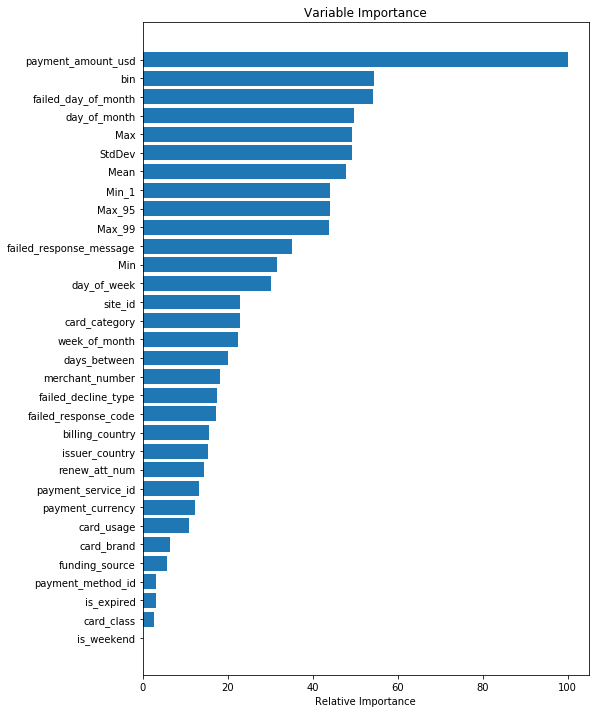

In [23]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''

model_id = 'ML-BR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


In [ ]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'max_delta_step':[1],  
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (4192314, 31)
x_test (1397439, 31)
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...
In fit best retry with Standard Scaler na = 0 .... 
features_dict:  {'FEATURES_CAT': ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'payment_currency', 'days_between', 'failed_response_message'], 'FEATURES_NUM': ['payment_amount_usd'], 'FEATURES_ENCODED': ['week_of_month', 'day_of_week', 'Mean', 'Min', 'Max', 'StdDev', 'Max_95', 'Max_99', 'Min_1', 'is_weekend', 'is_expired'], 'FEATURE

/var/spark/jupyter-notebooks/src/web/preprocessing.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'payment_currency', 'days_between', 'failed_response_message', 'week_of_month', 'day_of_week', 'is_weekend', 'is_expired', 'payment_amount_usd', 'Mean', 'Min', 'Max', 'StdDev', 'Max_95', 'Max_99', 'Min_1']
# fit_time: 92.0382809638977
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'payment_currency', 'days_between', 'failed_response_message', 'week_of_month', 'day_of_week',

/var/spark/jupyter-notebooks/src/web/preprocessing.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In transform best retry .... 
# transform_time: 15018.228819847107


best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (4192314, 31)
x_test (1397439, 31)
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...
In fit best retry with Standard Scaler na = 0 .... 
features_dict:  {'FEATURES_CAT': ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'payment_currency', 'days_between', 'failed_response_message'], 'FEATURES_NUM': ['payment_amount_usd'], 'FEATURES_ENCODED': ['week_of_month', 'day_of_week', 'Mean', 'Min', 'Max', 'StdDev', 'Max_95', 'Max_99', 'Min_1', 'is_weekend', 'is_expired'], 'FEATURE

/var/spark/jupyter-notebooks/src/web/preprocessing.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'payment_currency', 'days_between', 'failed_response_message', 'week_of_month', 'day_of_week', 'is_weekend', 'is_expired', 'payment_amount_usd', 'Mean', 'Min', 'Max', 'StdDev', 'Max_95', 'Max_99', 'Min_1']
# fit_time: 88.30715274810791
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'payment_currency', 'days_between', 'failed_response_message', 'week_of_month', 'day_of_week'

/var/spark/jupyter-notebooks/src/web/preprocessing.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In transform best retry .... 
# transform_time: 14987.119006633759
[09:33:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1212 extra nodes, 0 pruned nodes, max_depth=10
[09:34:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1280 extra nodes, 0 pruned nodes, max_depth=10
[09:34:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1228 extra nodes, 0 pruned nodes, max_depth=10
[09:35:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1202 extra nodes, 0 pruned nodes, max_depth=10
[09:35:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1290 extra nodes, 0 pruned nodes, max_depth=10
[09:36:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1304 extra nodes, 0 pruned nodes, max_depth=10
[09:36:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1336 extra nodes, 0 pruned nodes, max_depth=10
[09:37:15] /workspace/src/tree/updater_prune.cc:74:

[10:07:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 644 extra nodes, 0 pruned nodes, max_depth=10
[10:07:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=10
[10:08:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 pruned nodes, max_depth=10
[10:08:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=10
[10:09:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[10:09:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[10:10:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 768 extra nodes, 0 pruned nodes, max_depth=10
[10:10:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10


[10:40:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[10:41:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=10
[10:41:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[10:42:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[10:42:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=10
[10:43:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[10:43:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=10
[10:44:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=10


[11:13:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[11:14:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=10
[11:14:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 630 extra nodes, 0 pruned nodes, max_depth=10
[11:14:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=10
[11:15:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=10
[11:15:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[11:16:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[11:16:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 552 extra nodes, 0 pruned nodes, max_depth=10


[11:46:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 586 extra nodes, 0 pruned nodes, max_depth=10
[11:47:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[11:47:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=10
[11:48:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[11:48:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 536 extra nodes, 0 pruned nodes, max_depth=10
[11:49:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=10
[11:49:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=10
[11:50:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=10


[12:19:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[12:20:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[12:20:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[12:21:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[12:21:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=10
[12:22:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=10
[12:22:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=10
[12:23:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10


[12:52:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[12:53:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=10
[12:53:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=10
[12:54:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 530 extra nodes, 0 pruned nodes, max_depth=10
[12:55:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 0 pruned nodes, max_depth=10
[12:55:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=10
[12:56:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[12:56:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=10


[13:25:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=10
[13:26:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=10
[13:26:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[13:27:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 614 extra nodes, 0 pruned nodes, max_depth=10
[13:27:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[13:28:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=10
[13:28:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=10
[13:29:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10


[13:58:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[13:59:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[13:59:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[14:00:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[14:01:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 582 extra nodes, 0 pruned nodes, max_depth=10
[14:01:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=10
[14:02:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[14:02:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10


[14:32:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=10
[14:33:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=10
[14:33:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 578 extra nodes, 0 pruned nodes, max_depth=10
[14:33:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=10
[14:34:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=10
[14:34:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[14:35:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[14:35:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10


[15:05:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[15:06:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=10
[15:06:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 pruned nodes, max_depth=10
[15:07:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 556 extra nodes, 0 pruned nodes, max_depth=10
[15:07:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=10
[15:08:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[15:08:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 pruned nodes, max_depth=10
[15:09:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 0 pruned nodes, max_depth=10


[15:38:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[15:39:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[15:39:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[15:40:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=10
[15:40:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 0 pruned nodes, max_depth=10
[15:41:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=10
[15:41:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=10
[15:42:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=10


[16:12:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=10
[16:13:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=10
[16:13:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 538 extra nodes, 0 pruned nodes, max_depth=10
[16:14:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 516 extra nodes, 0 pruned nodes, max_depth=10
[16:14:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 544 extra nodes, 0 pruned nodes, max_depth=10
[16:15:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 622 extra nodes, 0 pruned nodes, max_depth=10
[16:15:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10
[16:16:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10


[16:45:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=10
[16:46:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=10
[16:46:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 638 extra nodes, 0 pruned nodes, max_depth=10
[16:47:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 596 extra nodes, 0 pruned nodes, max_depth=10
[16:47:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=10
[16:48:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=10
[16:48:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=10
[16:49:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10


[17:19:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 516 extra nodes, 0 pruned nodes, max_depth=10
[17:20:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=10
[17:20:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 560 extra nodes, 0 pruned nodes, max_depth=10
[17:21:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 524 extra nodes, 0 pruned nodes, max_depth=10
[17:21:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=10
[17:22:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=10
[17:22:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=10
[17:23:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=10


[17:53:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 544 extra nodes, 0 pruned nodes, max_depth=10
[17:54:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=10
[17:54:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=10
[17:55:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 0 pruned nodes, max_depth=10
[17:55:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 622 extra nodes, 0 pruned nodes, max_depth=10
[17:56:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=10
[17:56:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=10
[17:57:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 0 pruned nodes, max_depth=10


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


pipe: EnhancedPipeline(memory=None,
         steps=[('preprocessing', PreProcessing(df_bin_profile=None)), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_...,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
       subsample=0.5))])
training accuracy: 0.98399762040725
training auc: 0.9690006870545046
             precision    recall  f1-score   support

          0       0.99      0.99      0.99   3372786
          1       0.97      0.94      0.96    819528

avg / total       0.98      0.98      0.98   4192314



/var/spark/jupyter-notebooks/src/web/preprocessing.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In transform best retry .... 
# transform_time: 3964.6156389713287


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# training time: 56795.576132535934
feature_importance column  Index(['is_weekend', 'card_class', 'is_expired', 'card_brand',
       'payment_method_id', 'funding_source', 'card_usage', 'payment_currency',
       'issuer_country', 'billing_country', 'failed_response_code',
       'renew_att_num', 'payment_service_id', 'failed_decline_type',
       'card_category', 'days_between', 'week_of_month', 'merchant_number',
       'day_of_week', 'site_id', 'Min', 'failed_response_message', 'Min_1',
       'Max_95', 'Max_99', 'day_of_month', 'StdDev', 'failed_day_of_month',
       'Mean', 'Max', 'bin', 'payment_amount_usd'],
      dtype='object')
feature_importance val  [  0.          2.410661    3.9512773   5.954503    5.954503    6.349206
  14.909599   15.800865   16.849165   17.108055   21.122995   21.449791
  21.79781    22.413208   23.206858   24.475851   24.730497   25.999493
  30.69349    31.60173    33.91902    39.147778   47.092777   47.814278
  50.386215   51.111954   53.221287   55.19

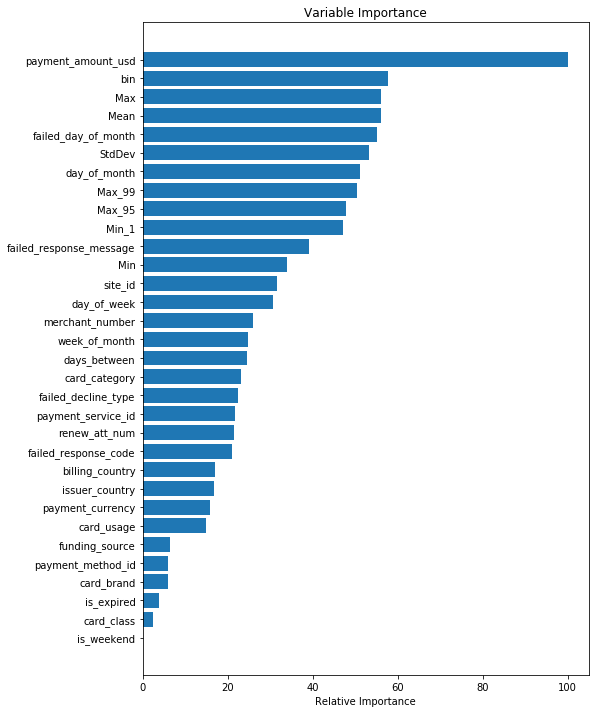

In [17]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


/var/spark/jupyter-notebooks/src/web/preprocessing.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[DAY_OF_WEEK] = df[TXN_DATE_IN_STR].apply(to_weekday)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'payment_currency', 'days_between', 'failed_response_message', 'week_of_month', 'day_of_week', 'is_weekend', 'is_expired', 'payment_amount_usd', 'Mean', 'Min', 'Max', 'StdDev', 'Max_95', 'Max_99', 'Min_1']
# fit_time: 155.33194160461426
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'payment_currency', 'days_between', 'failed_response_message', 'week_of_month', 'day_of_week

/var/spark/jupyter-notebooks/src/web/preprocessing.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In transform best retry .... 
# transform_time: 24019.130719184875
[01:07:32] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[01:08:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1416 extra nodes, 0 pruned nodes, max_depth=10
[01:09:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1424 extra nodes, 0 pruned nodes, max_depth=10
[01:10:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1472 extra nodes, 0 pruned nodes, max_depth=10
[01:11:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1474 extra nodes, 0 pruned nodes, max_depth=10
[01:12:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1494 extra nodes, 0 pruned nodes, max_depth=10
[01:13:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1490 extra nodes, 0 pruned nodes, max_depth=10
[01:1

[02:04:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 582 extra nodes, 0 pruned nodes, max_depth=10
[02:05:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 966 extra nodes, 0 pruned nodes, max_depth=10
[02:06:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[02:07:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 538 extra nodes, 0 pruned nodes, max_depth=10
[02:08:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=10
[02:08:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 822 extra nodes, 0 pruned nodes, max_depth=10
[02:09:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[02:10:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 934 extra nodes, 0 pruned nodes, max_depth=10


[03:01:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 696 extra nodes, 0 pruned nodes, max_depth=10
[03:02:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[03:03:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 564 extra nodes, 0 pruned nodes, max_depth=10
[03:04:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[03:05:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 788 extra nodes, 0 pruned nodes, max_depth=10
[03:06:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 544 extra nodes, 0 pruned nodes, max_depth=10
[03:07:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[03:07:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 648 extra nodes, 0 pruned nodes, max_depth=10


[03:58:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=10
[03:59:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pruned nodes, max_depth=10
[04:00:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 636 extra nodes, 0 pruned nodes, max_depth=10
[04:01:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=10
[04:02:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=10
[04:03:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 576 extra nodes, 0 pruned nodes, max_depth=10
[04:04:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=10
[04:05:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10


[04:56:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[04:57:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 734 extra nodes, 0 pruned nodes, max_depth=10
[04:58:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[04:58:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=10
[04:59:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[05:00:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[05:01:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=10
[05:02:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10


[05:54:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[05:55:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 554 extra nodes, 0 pruned nodes, max_depth=10
[05:56:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=10
[05:56:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 586 extra nodes, 0 pruned nodes, max_depth=10
[05:57:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=10
[05:58:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[05:59:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=10
[06:00:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10


[06:51:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=10
[06:51:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=10
[06:52:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=10
[06:53:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=10
[06:54:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=10
[06:55:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[06:56:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=10
[06:57:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10


[07:48:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 702 extra nodes, 0 pruned nodes, max_depth=10
[07:49:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 542 extra nodes, 0 pruned nodes, max_depth=10
[07:50:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 532 extra nodes, 0 pruned nodes, max_depth=10
[07:51:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[07:52:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 638 extra nodes, 0 pruned nodes, max_depth=10
[07:53:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[07:54:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[07:54:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 532 extra nodes, 0 pruned nodes, max_depth=10


[08:46:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 576 extra nodes, 0 pruned nodes, max_depth=10
[08:47:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=10
[08:48:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 738 extra nodes, 0 pruned nodes, max_depth=10
[08:49:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 542 extra nodes, 0 pruned nodes, max_depth=10
[08:50:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 556 extra nodes, 0 pruned nodes, max_depth=10
[08:50:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[08:51:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 574 extra nodes, 0 pruned nodes, max_depth=10
[08:52:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 702 extra nodes, 0 pruned nodes, max_depth=10


[09:44:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=10
[09:45:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 906 extra nodes, 0 pruned nodes, max_depth=10
[09:46:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[09:47:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 654 extra nodes, 0 pruned nodes, max_depth=10
[09:48:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=10
[09:49:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=10
[09:50:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[09:50:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10


[10:42:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 0 pruned nodes, max_depth=10
[10:43:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[10:44:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 538 extra nodes, 0 pruned nodes, max_depth=10
[10:45:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 592 extra nodes, 0 pruned nodes, max_depth=10
[10:46:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 608 extra nodes, 0 pruned nodes, max_depth=10
[10:47:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 570 extra nodes, 0 pruned nodes, max_depth=10
[10:47:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=10
[10:48:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 912 extra nodes, 0 pruned nodes, max_depth=10


[11:40:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 658 extra nodes, 0 pruned nodes, max_depth=10
[11:41:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 590 extra nodes, 0 pruned nodes, max_depth=10
[11:42:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[11:43:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 612 extra nodes, 0 pruned nodes, max_depth=10
[11:44:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=10
[11:45:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 724 extra nodes, 0 pruned nodes, max_depth=10
[11:45:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=10
[11:46:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 808 extra nodes, 0 pruned nodes, max_depth=10


[12:38:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 668 extra nodes, 0 pruned nodes, max_depth=10
[12:39:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[12:40:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 758 extra nodes, 0 pruned nodes, max_depth=10
[12:41:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=10
[12:41:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=10
[12:42:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[12:43:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 582 extra nodes, 0 pruned nodes, max_depth=10
[12:44:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 582 extra nodes, 0 pruned nodes, max_depth=10


[13:35:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 600 extra nodes, 0 pruned nodes, max_depth=10
[13:36:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=10
[13:37:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 804 extra nodes, 0 pruned nodes, max_depth=10
[13:38:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 580 extra nodes, 0 pruned nodes, max_depth=10
[13:38:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 656 extra nodes, 0 pruned nodes, max_depth=10
[13:39:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=10
[13:40:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 594 extra nodes, 0 pruned nodes, max_depth=10
[13:41:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 558 extra nodes, 0 pruned nodes, max_depth=10


[14:32:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[14:33:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=10
[14:34:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[14:35:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 534 extra nodes, 0 pruned nodes, max_depth=10
[14:36:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 694 extra nodes, 0 pruned nodes, max_depth=10
[14:36:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=10
[14:37:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 740 extra nodes, 0 pruned nodes, max_depth=10
[14:38:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 618 extra nodes, 0 pruned nodes, max_depth=10


[15:29:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=10
[15:30:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=10
[15:31:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 654 extra nodes, 0 pruned nodes, max_depth=10
[15:32:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[15:33:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 556 extra nodes, 0 pruned nodes, max_depth=10
[15:34:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 674 extra nodes, 0 pruned nodes, max_depth=10
[15:34:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=10
[15:35:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


pipe: EnhancedPipeline(memory=None,
         steps=[('preprocessing', PreProcessing(df_bin_profile=None)), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_...,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
       subsample=0.5))])
training accuracy: 0.9827227551566614
training auc: 0.9827233805803097
             precision    recall  f1-score   support

          0       0.98      0.98      0.98   3374150
          1       0.98      0.98      0.98   3371833

avg / total       0.98      0.98      0.98   6745983



/var/spark/jupyter-notebooks/src/web/preprocessing.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In transform best retry .... 
# transform_time: 6766.269853591919


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# training time: 94416.26558423042
feature_importance column  Index(['is_weekend', 'card_class', 'is_expired', 'payment_method_id',
       'card_brand', 'funding_source', 'card_usage', 'payment_currency',
       'issuer_country', 'billing_country', 'failed_response_code',
       'failed_decline_type', 'payment_service_id', 'renew_att_num',
       'card_category', 'days_between', 'merchant_number', 'week_of_month',
       'site_id', 'Min', 'day_of_week', 'failed_response_message', 'Min_1',
       'Max_95', 'Max_99', 'StdDev', 'failed_day_of_month', 'Mean',
       'day_of_month', 'Max', 'bin', 'payment_amount_usd'],
      dtype='object')
feature_importance val  [  0.          2.3106034   3.5588603   3.5986986   5.8694644   6.188168
  13.554877   14.786535   15.145077   15.340946   18.365313   18.806852
  20.45349    20.685877   21.074299   21.592192   22.00717    22.335833
  29.211208   29.443594   32.610714   33.281322   42.191753   42.67313
  44.761303   45.55474    49.239758   49.2464

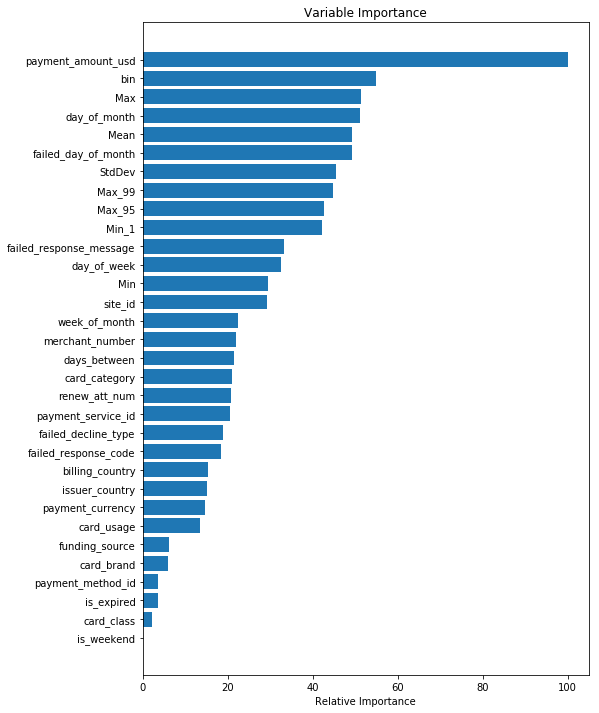

In [38]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
# for idx, df_2018_f in enumerate(df_2018_filtered):
#     print("Iteration: ", idx)
model_id = 'ML-BR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
retry_success_balanced_all = retry_success_balanced_all.reset_index()

xgb_clf, result_d = build_and_train(retry_success_balanced_all, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


In [84]:
model_file

['/var/spark/ml_files/models/ML-BR-1.69.pkl']

In [122]:
retry_success['bin']

0           456460.0
1           456441.0
2           498401.0
3           423365.0
4           540448.0
5           418345.0
6           547206.0
7           469307.0
8           430023.0
9           477376.0
10          513283.0
11          426344.0
12          454742.0
13          457973.0
14          532533.0
15          512687.0
16          416202.0
17          377045.0
18          438951.0
19          542011.0
20          486312.0
21          457973.0
22          463225.0
23          427638.0
24          404386.0
25          425032.0
26          534207.0
27          517805.0
28          479853.0
29          371296.0
              ...   
10761294    540187.0
10761295    463158.0
10761296    498453.0
10761297    549852.0
10761298    442062.0
10761299    552260.0
10761300    540791.0
10761301    531015.0
10761302    497203.0
10761303    427638.0
10761304    450906.0
10761305    445230.0
10761306    517805.0
10761307    536510.0
10761308    554505.0
10761309    437551.0
10761310    4

In [128]:
retry_success_10.to_csv(WORK_DIR + 'retry_success_10.csv')

best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (1062330, 31)
x_test (354110, 31)
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...
In fit best retry with Standard Scaler .... 
features_dict:  {'FEATURES_CAT': ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'payment_currency', 'days_between', 'failed_response_message'], 'FEATURES_NUM': ['payment_amount_usd'], 'FEATURES_ENCODED': ['week_of_month', 'day_of_week', 'Mean', 'Min', 'Max', 'StdDev', 'Max_95', 'Max_99', 'Min_1', 'is_weekend', 'is_expired'], 'FEATURES_NUM_EN

/var/spark/jupyter-notebooks/src/web/preprocessing.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[DAY_OF_WEEK] = df[TXN_DATE_IN_STR].apply(to_weekday)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'payment_currency', 'days_between', 'failed_response_message', 'week_of_month', 'day_of_week', 'is_weekend', 'is_expired', 'payment_amount_usd', 'Mean', 'Min', 'Max', 'StdDev', 'Max_95', 'Max_99', 'Min_1']
# fit_time: 10.651262998580933
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'payment_currency', 'days_between', 'failed_response_message', 'week_of_month', 'day_of_week

/var/spark/jupyter-notebooks/src/web/preprocessing.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[DAY_OF_WEEK] = df[TXN_DATE_IN_STR].apply(to_weekday)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In transform best retry .... 
# transform_time: 1376.7811121940613
[14:57:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 704 extra nodes, 0 pruned nodes, max_depth=10
[14:57:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 720 extra nodes, 0 pruned nodes, max_depth=10
[14:57:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1060 extra nodes, 0 pruned nodes, max_depth=10
[14:57:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 884 extra nodes, 0 pruned nodes, max_depth=10
[14:57:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 780 extra nodes, 0 pruned nodes, max_depth=10
[14:57:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 878 extra nodes, 0 pruned nodes, max_depth=10
[14:57:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 794 extra nodes, 0 pruned nodes, max_depth=10
[14:57:54] /workspace/src/tree/updater_prune.cc:74: tree 

[15:02:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[15:02:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=10
[15:02:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[15:02:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[15:02:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[15:03:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[15:03:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[15:03:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10


[15:07:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[15:07:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[15:08:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=10
[15:08:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=10
[15:08:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[15:08:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[15:08:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10
[15:08:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10


[15:13:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=10
[15:13:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[15:13:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[15:13:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[15:13:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[15:13:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[15:13:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=10
[15:13:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10


[15:18:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[15:18:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[15:18:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[15:18:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[15:18:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[15:18:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[15:18:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[15:18:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10


[15:23:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[15:23:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[15:23:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[15:23:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[15:23:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[15:24:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[15:24:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=10
[15:24:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10


[15:28:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[15:28:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[15:28:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[15:29:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[15:29:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[15:29:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[15:29:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[15:29:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10


[15:35:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[15:35:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=10
[15:35:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=10
[15:35:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[15:36:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[15:36:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=10
[15:36:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[15:36:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10


[15:40:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[15:40:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10
[15:41:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[15:41:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[15:41:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[15:41:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[15:41:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=10
[15:41:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10


[15:46:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[15:46:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[15:46:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[15:46:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[15:46:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[15:46:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[15:46:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10
[15:46:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10


[15:51:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[15:51:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[15:51:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[15:51:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[15:51:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=10
[15:51:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=10
[15:51:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[15:51:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10


[15:56:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[15:56:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[15:56:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[15:56:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[15:56:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[15:56:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[15:56:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[15:57:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=10


[16:01:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[16:01:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10
[16:01:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[16:01:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[16:02:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[16:02:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[16:02:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[16:02:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10


[16:06:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[16:06:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10
[16:07:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[16:07:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[16:07:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[16:07:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[16:07:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[16:07:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=10


[16:12:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[16:12:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[16:12:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[16:12:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[16:12:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[16:12:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[16:12:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[16:12:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


pipe: EnhancedPipeline(memory=None,
         steps=[('preprocessing', PreProcessing(df_bin_profile=None)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=10, min_child_weight=11, missing=-999, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=0,
       subsample=0.5))])
training accuracy: 0.9970028145679779
training auc: 0.9909751472353645
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    924141
          1       0.99      0.98      0.99    138189

avg / total       1.00      1.00      1.00   1062330



/var/spark/jupyter-notebooks/src/web/preprocessing.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[DAY_OF_WEEK] = df[TXN_DATE_IN_STR].apply(to_weekday)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In transform best retry .... 
# transform_time: 442.3447172641754


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# training time: 7602.387389659882
feature_importance column  Index(['is_weekend', 'card_class', 'is_expired', 'payment_method_id',
       'funding_source', 'card_brand', 'card_usage', 'payment_currency',
       'billing_country', 'failed_response_code', 'payment_service_id',
       'issuer_country', 'failed_decline_type', 'merchant_number',
       'week_of_month', 'card_category', 'site_id', 'day_of_week',
       'days_between', 'renew_att_num', 'Min', 'failed_response_message',
       'bin', 'Max_95', 'failed_day_of_month', 'Max_99', 'Min_1',
       'day_of_month', 'Mean', 'StdDev', 'Max', 'payment_amount_usd'],
      dtype='object')
feature_importance val  [  0.          1.5898678   2.1085958   5.0525465   5.194018    5.672325
  13.81703    15.952572   16.491512   16.94961    17.077606   17.414444
  18.101587   22.136889   23.753704   25.255997   27.559958   28.327942
  29.479923   30.389383   34.465103   35.1253     44.46241    46.92805
  48.133926   51.886284   52.07491    52.8294

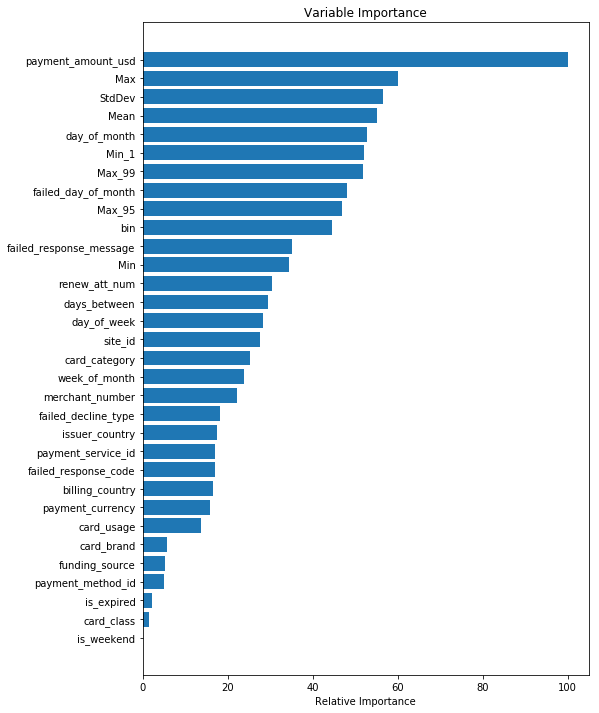

In [192]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
# for idx, df_2018_f in enumerate(df_2018_filtered):
#     print("Iteration: ", idx)
model_id = 'ML-BR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success_10, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (1030538, 31)
x_test (343513, 31)
training xgb ....... 
In fit best retry with Standard Scaler .... 
features_dict:  {'FEATURES_CAT': ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'payment_currency', 'days_between', 'failed_response_message'], 'FEATURES_NUM': ['payment_amount_usd'], 'FEATURES_ENCODED': ['week_of_month', 'day_of_week', 'Mean', 'Min', 'Max', 'StdDev', 'Max_95', 'Max_99', 'Min_1', 'is_weekend', 'is_expired'], 'FEATURES_NUM_ENCODED': ['Mean', 'Min', 'Max', 'StdDev', 'Max_95', 'Max_99', 'Min_1']}


/var/spark/jupyter-notebooks/src/web/preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[IS_EXPIRED] = df[~df['cc_expiration_date'].isna()].apply(is_expired, axis=1)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[IS_WEEKEND] = df[DAY_OF_WEEK].apply(is_weekend)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'payment_currency', 'days_between', 'failed_response_message', 'week_of_month', 'day_of_week', 'is_weekend', 'is_expired', 'payment_amount_usd', 'Mean', 'Min', 'Max', 'StdDev', 'Max_95', 'Max_99', 'Min_1']
# fit_time: 9.116622686386108
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'payment_currency', 'days_between', 'failed_response_message', 'week_of_month', 'day_of_week'

/var/spark/jupyter-notebooks/src/web/preprocessing.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[DAY_OF_WEEK] = df[TXN_DATE_IN_STR].apply(to_weekday)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In transform best retry .... 
# transform_time: 1260.8126587867737
[05:56:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 864 extra nodes, 0 pruned nodes, max_depth=10
[05:57:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 708 extra nodes, 0 pruned nodes, max_depth=10
[05:57:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 810 extra nodes, 0 pruned nodes, max_depth=10
[05:57:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 852 extra nodes, 0 pruned nodes, max_depth=10
[05:57:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 678 extra nodes, 0 pruned nodes, max_depth=10
[05:57:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 986 extra nodes, 0 pruned nodes, max_depth=10
[05:57:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 830 extra nodes, 0 pruned nodes, max_depth=10
[05:57:26] /workspace/src/tree/updater_prune.cc:74: tree p

[06:01:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[06:01:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[06:01:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[06:01:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[06:01:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[06:01:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[06:01:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[06:01:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10


[06:04:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10
[06:05:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[06:05:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[06:05:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[06:05:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=10
[06:05:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[06:05:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[06:05:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10


[06:08:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[06:08:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[06:08:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[06:09:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[06:09:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[06:09:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[06:09:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[06:09:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10


[06:12:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[06:12:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[06:12:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[06:12:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[06:12:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[06:12:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[06:13:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[06:13:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10


[06:16:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[06:16:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[06:16:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[06:16:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[06:16:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[06:16:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[06:16:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=10
[06:16:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10


[06:20:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10
[06:20:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[06:20:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[06:20:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[06:20:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[06:20:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[06:20:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[06:20:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10


[06:24:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[06:24:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=10
[06:24:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[06:24:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[06:24:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[06:24:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[06:24:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[06:24:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=10


[06:28:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[06:28:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[06:28:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10
[06:28:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10
[06:28:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=10
[06:28:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[06:28:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=10
[06:28:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10


[06:32:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[06:32:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[06:32:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[06:32:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[06:32:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=10
[06:32:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[06:32:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[06:32:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10


[06:36:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[06:36:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[06:36:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[06:36:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[06:36:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[06:36:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[06:36:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[06:36:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10


[06:39:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[06:39:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[06:40:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[06:40:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[06:40:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[06:40:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[06:40:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[06:40:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=10


[06:43:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[06:43:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[06:43:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[06:44:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[06:44:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[06:44:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=10
[06:44:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[06:44:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10


[06:47:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[06:47:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[06:47:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[06:47:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[06:48:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[06:48:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[06:48:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[06:48:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10


[06:51:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[06:51:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=10
[06:51:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[06:51:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[06:51:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[06:51:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[06:52:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[06:52:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=10


[06:55:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[06:55:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[06:55:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[06:55:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=10
[06:55:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[06:55:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[06:55:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[06:55:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10


/var/spark/jupyter-notebooks/src/web/preprocessing.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[DAY_OF_WEEK] = df[TXN_DATE_IN_STR].apply(to_weekday)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In transform best retry .... 
# transform_time: 1266.8023273944855


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


training accuracy: 0.9971636174503027
training auc: 0.9913621478076622
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    897011
          1       0.99      0.98      0.99    133527

avg / total       1.00      1.00      1.00   1030538

In transform best retry .... 
# transform_time: 416.6390595436096


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# training time: 7706.6130475997925
feature_importance column  Index(['is_weekend', 'card_class', 'is_expired', 'payment_method_id',
       'card_brand', 'funding_source', 'card_usage', 'issuer_country',
       'failed_response_code', 'billing_country', 'payment_currency',
       'payment_service_id', 'failed_decline_type', 'merchant_number',
       'week_of_month', 'card_category', 'renew_att_num', 'days_between',
       'site_id', 'day_of_week', 'failed_response_message', 'Min', 'bin',
       'failed_day_of_month', 'Max_95', 'Max_99', 'Min_1', 'day_of_month',
       'StdDev', 'Mean', 'Max', 'payment_amount_usd'],
      dtype='object')
feature_importance val  [  0.          2.245659    2.5398192   5.567513    6.4141192   6.8015494
  14.141196   16.343807   16.86038    17.140192   17.30521    19.464773
  20.813602   23.496914   24.630507   26.158703   27.529058   28.913761
  29.667097   31.381834   36.389725   36.590614   49.311237   50.81073
  52.123688   52.618736   53.034866   54.29

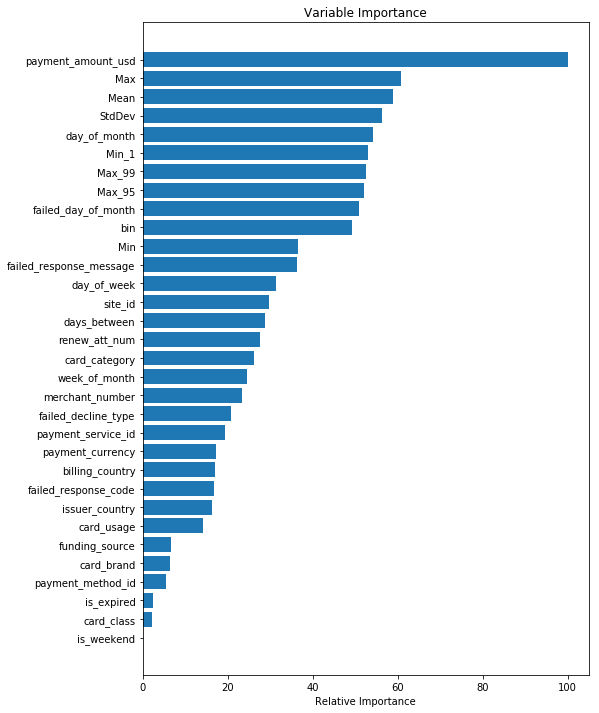

In [94]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
# for idx, df_2018_f in enumerate(df_2018_filtered):
#     print("Iteration: ", idx)
model_id = 'ML-BR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success_10, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (8070993, 31)
x_test (2690331, 31)
training xgb ....... 
features_dict:  {'FEATURES_CAT': ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'payment_currency', 'days_between', 'failed_response_message'], 'FEATURES_NUM': ['payment_amount_usd'], 'FEATURES_ENCODED': ['week_of_month', 'day_of_week', 'Mean', 'Min', 'Max', 'StdDev', 'Max_95', 'Max_99', 'Min_1', 'is_weekend', 'is_expired'], 'FEATURES_NUM_ENCODED': ['Mean', 'Min', 'Max', 'StdDev', 'Max_95', 'Max_99', 'Min_1']}


/var/spark/jupyter-notebooks/src/web/preprocessing.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[DAY_OF_WEEK] = df[TXN_DATE_IN_STR].apply(to_weekday)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'payment_currency', 'days_between', 'failed_response_message', 'week_of_month', 'day_of_week', 'is_weekend', 'is_expired', 'payment_amount_usd', 'Mean', 'Min', 'Max', 'StdDev', 'Max_95', 'Max_99', 'Min_1']
# fit_time: 179.15510296821594
In fit, self.encoder: 
EnhancedLeaveOneOutEncoder(cols=['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'payment_currency', 'days_between', 'failed_response_message', 'week_of_month', 'day_of_week

/var/spark/jupyter-notebooks/src/web/preprocessing.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[DAY_OF_WEEK] = df[TXN_DATE_IN_STR].apply(to_weekday)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In transform .... 
# transform_time: 31100.895870923996
[13:51:52] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[13:53:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1434 extra nodes, 0 pruned nodes, max_depth=10
[13:54:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1134 extra nodes, 0 pruned nodes, max_depth=10
[13:55:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1266 extra nodes, 0 pruned nodes, max_depth=10
[13:56:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1186 extra nodes, 0 pruned nodes, max_depth=10
[13:57:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1262 extra nodes, 0 pruned nodes, max_depth=10
[13:58:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1224 extra nodes, 0 pruned nodes, max_depth=10
[13:59:37] /work

[14:57:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 638 extra nodes, 0 pruned nodes, max_depth=10
[14:58:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 554 extra nodes, 0 pruned nodes, max_depth=10
[14:59:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1022 extra nodes, 0 pruned nodes, max_depth=10
[15:00:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1058 extra nodes, 0 pruned nodes, max_depth=10
[15:01:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1224 extra nodes, 0 pruned nodes, max_depth=10
[15:02:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 600 extra nodes, 0 pruned nodes, max_depth=10
[15:03:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 524 extra nodes, 0 pruned nodes, max_depth=10
[15:04:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 966 extra nodes, 0 pruned nodes, max_depth=

[16:02:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=10
[16:03:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=10
[16:04:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 810 extra nodes, 0 pruned nodes, max_depth=10
[16:05:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 0 pruned nodes, max_depth=10
[16:06:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 568 extra nodes, 0 pruned nodes, max_depth=10
[16:07:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 604 extra nodes, 0 pruned nodes, max_depth=10
[16:08:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 730 extra nodes, 0 pruned nodes, max_depth=10
[16:09:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10


[17:07:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[17:08:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 544 extra nodes, 0 pruned nodes, max_depth=10
[17:09:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 624 extra nodes, 0 pruned nodes, max_depth=10
[17:10:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[17:11:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 662 extra nodes, 0 pruned nodes, max_depth=10
[17:12:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=10
[17:13:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 790 extra nodes, 0 pruned nodes, max_depth=10
[17:14:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10


[18:12:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[18:13:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 588 extra nodes, 0 pruned nodes, max_depth=10
[18:14:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 550 extra nodes, 0 pruned nodes, max_depth=10
[18:15:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[18:16:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 624 extra nodes, 0 pruned nodes, max_depth=10
[18:17:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=10
[18:18:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=10
[18:19:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 766 extra nodes, 0 pruned nodes, max_depth=10


[19:16:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[19:17:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 774 extra nodes, 0 pruned nodes, max_depth=10
[19:18:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 590 extra nodes, 0 pruned nodes, max_depth=10
[19:19:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 526 extra nodes, 0 pruned nodes, max_depth=10
[19:20:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=10
[19:21:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[19:22:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 776 extra nodes, 0 pruned nodes, max_depth=10
[19:23:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10


[20:20:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=10
[20:21:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[20:22:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[20:23:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 656 extra nodes, 0 pruned nodes, max_depth=10
[20:24:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 704 extra nodes, 0 pruned nodes, max_depth=10
[20:25:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[20:26:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 662 extra nodes, 0 pruned nodes, max_depth=10
[20:27:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10


[21:25:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=10
[21:26:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=10
[21:27:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=10
[21:28:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 700 extra nodes, 0 pruned nodes, max_depth=10
[21:29:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=10
[21:30:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 610 extra nodes, 0 pruned nodes, max_depth=10
[21:31:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[21:32:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 950 extra nodes, 0 pruned nodes, max_depth=10


[22:30:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 688 extra nodes, 0 pruned nodes, max_depth=10
[22:31:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[22:32:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=10
[22:33:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 566 extra nodes, 0 pruned nodes, max_depth=10
[22:34:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 516 extra nodes, 0 pruned nodes, max_depth=10
[22:35:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 786 extra nodes, 0 pruned nodes, max_depth=10
[22:36:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 644 extra nodes, 0 pruned nodes, max_depth=10
[22:37:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=10


[23:35:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 778 extra nodes, 0 pruned nodes, max_depth=10
[23:36:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=10
[23:37:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=10
[23:38:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 582 extra nodes, 0 pruned nodes, max_depth=10
[23:39:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 776 extra nodes, 0 pruned nodes, max_depth=10
[23:40:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[23:41:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 0 pruned nodes, max_depth=10
[23:42:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=10


[00:40:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=10
[00:41:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[00:42:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 666 extra nodes, 0 pruned nodes, max_depth=10
[00:43:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 776 extra nodes, 0 pruned nodes, max_depth=10
[00:44:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 592 extra nodes, 0 pruned nodes, max_depth=10
[00:45:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 648 extra nodes, 0 pruned nodes, max_depth=10
[00:46:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[00:47:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 530 extra nodes, 0 pruned nodes, max_depth=10


[01:45:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 666 extra nodes, 0 pruned nodes, max_depth=10
[01:46:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 626 extra nodes, 0 pruned nodes, max_depth=10
[01:47:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 688 extra nodes, 0 pruned nodes, max_depth=10
[01:48:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[01:49:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=10
[01:50:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 790 extra nodes, 0 pruned nodes, max_depth=10
[01:51:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[01:52:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 848 extra nodes, 0 pruned nodes, max_depth=10


[02:50:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[02:51:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=10
[02:52:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 822 extra nodes, 0 pruned nodes, max_depth=10
[02:53:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 590 extra nodes, 0 pruned nodes, max_depth=10
[02:54:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=10
[02:55:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 790 extra nodes, 0 pruned nodes, max_depth=10
[02:56:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 642 extra nodes, 0 pruned nodes, max_depth=10
[02:57:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=10


[03:56:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 674 extra nodes, 0 pruned nodes, max_depth=10
[03:57:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 674 extra nodes, 0 pruned nodes, max_depth=10
[03:58:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 768 extra nodes, 0 pruned nodes, max_depth=10
[03:59:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 568 extra nodes, 0 pruned nodes, max_depth=10
[04:00:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 820 extra nodes, 0 pruned nodes, max_depth=10
[04:01:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=10
[04:02:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 596 extra nodes, 0 pruned nodes, max_depth=10
[04:03:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 616 extra nodes, 0 pruned nodes, max_depth=10


[05:01:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=10
[05:02:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=10
[05:03:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 634 extra nodes, 0 pruned nodes, max_depth=10
[05:04:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=10
[05:05:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=10
[05:06:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[05:07:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=10
[05:08:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 668 extra nodes, 0 pruned nodes, max_depth=10


[06:05:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=10
[06:06:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[06:07:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 834 extra nodes, 0 pruned nodes, max_depth=10
[06:08:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 552 extra nodes, 0 pruned nodes, max_depth=10
[06:09:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[06:10:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=10
[06:11:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=10
[06:12:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 732 extra nodes, 0 pruned nodes, max_depth=10


/var/spark/jupyter-notebooks/src/web/preprocessing.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[DAY_OF_WEEK] = df[TXN_DATE_IN_STR].apply(to_weekday)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In transform .... 
# transform_time: 31722.19690513611


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In transform .... 
# transform_time: 9027.603188991547


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# training time: 141151.78110194206
feature_importance column  Index(['is_weekend', 'is_expired', 'card_class', 'payment_method_id',
       'card_brand', 'funding_source', 'payment_service_id',
       'payment_currency', 'card_usage', 'billing_country', 'issuer_country',
       'merchant_number', 'failed_decline_type', 'failed_response_code',
       'card_category', 'site_id', 'week_of_month', 'renew_att_num',
       'days_between', 'failed_response_message', 'day_of_week', 'Min',
       'failed_day_of_month', 'Max_95', 'Max_99', 'Min_1', 'StdDev', 'Max',
       'Mean', 'bin', 'day_of_month', 'payment_amount_usd'],
      dtype='object')
feature_importance val  [  0.          2.3240879   2.3883061   3.4953063   4.4891596   6.223051
  11.002722   11.375799   13.109692   13.565334   13.761048   14.283967
  14.782423   14.831352   20.81282    23.13079    24.320358   25.19189
  27.907404   27.922695   31.40271    31.647352   33.88581    40.436073
  41.023212   41.448273   44.212715   47.050

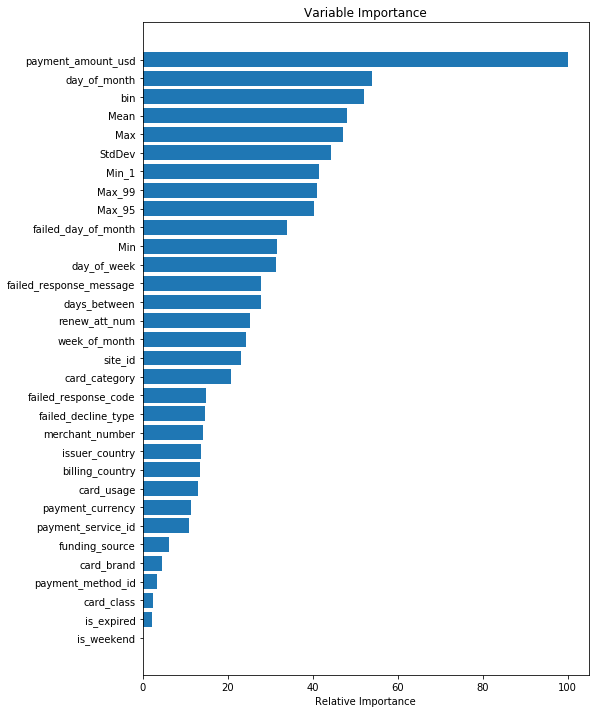

In [20]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
# for idx, df_2018_f in enumerate(df_2018_filtered):
#     print("Iteration: ", idx)
model_id = 'ML-BR-1'
version = get_latest_version(model_id) + 1
model_name = model_id + '.' + str(version)
xgb_clf, result_d = build_and_train(retry_success, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


In [60]:

""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BR-1'
version = get_latest_version(model_id) + 1

# for idx, df_2018_f in enumerate(df_2018_filtered):
#     print("Iteration: ", idx)
dates = ['201801','201802','201803','201804','201805','201806']
for idx, date in enumerate(dates):
    print(date)
    model_name = model_id + '.' + str(version) + '.' + str(idx)
    print(model_name)
    retry_success_ = retry_success[retry_success['received_date'].astype(str).str.startswith(date)]
    retry_success_balanced_all_ = balancing_class(retry_success_)
    xgb_clf, result_d = build_and_train(retry_success_balanced_all_, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
    model_file, model_file_name = write_model(xgb_clf, model_name)
    print("model_file is generated: ", model_file)
    print("result_dict: ", result_d)


201801
ML-BR-1.41.0
0    0.885533
1    0.114467
Name: success, dtype: float64
1    0.5
0    0.5
Name: success, dtype: float64
(185072, 61)
best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (138804, 20)
x_test (46268, 20)
training xgb ....... 
features_dict:  {'FEATURES_CAT': ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'is_weekend'], 'FEATURES_NUM': ['payment_amount_usd'], 'FEATURES_ENCODED': ['week_of_month', 'day_of_week', 'Mean', 'Min', 'Max', 'StdDev']}
self.features_list:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issue

self.features_list:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'is_weekend', 'week_of_month', 'day_of_week', 'Mean', 'Min', 'Max', 'StdDev', 'payment_amount_usd']
# training time: 868.5848796367645
features_dict:  {'FEATURES_CAT': ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'is_weekend'], 'FEATURES_NUM': ['payment_amount_usd'], 'FEATURES_ENCODED': ['week_of_month', 'day_of_week', 'Mean', 'Min', 'Max', 'StdDev']}
self.features_list:  ['card_brand', 'funding_source', 'card_category', 'ca

self.features_list:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'is_weekend', 'week_of_month', 'day_of_week', 'Mean', 'Min', 'Max', 'StdDev', 'payment_amount_usd']
accuracy_dummy: 0.49990128888512847
training accuracy: 0.9891417773641312
             precision    recall  f1-score   support

          0       0.99      0.98      0.99    106378
          1       0.98      0.99      0.99    106364

avg / total       0.99      0.99      0.99    212742

test accuracy: 0.9349493752996587
             precision    recall  f1-score   support

          0       0.95      0.92      0.93     35450
          1       0.92      0.95      0.94     35464

avg / total       0.94      0.93      0.93     70914

# confusion_matrix -  test:
 [[32665  2785]

In [64]:

""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337}

model_file = ''
model_id = 'ML-BR-1'
version = get_latest_version(model_id) + 1

# for idx, df_2018_f in enumerate(df_2018_filtered):
#     print("Iteration: ", idx)
dates = ['201801','201802','201803','201804','201805','201806']
for idx, date in enumerate(dates):
    print(date)
    model_name = model_id + '.' + str(version) + '.' + str(idx)
    print(model_name)
    retry_success_ = retry_success[retry_success['received_date'].astype(str).str.startswith(date)]
    retry_success_balanced_all_ = balancing_class(retry_success_)
    xgb_clf, result_d = build_and_train(retry_success_balanced_all_, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
    model_file, model_file_name = write_model(xgb_clf, model_name)
    print("model_file is generated: ", model_file)
    print("result_dict: ", result_d)


201801
ML-BR-1.42.0
0    0.885533
1    0.114467
Name: success, dtype: float64
1    0.5
0    0.5
Name: success, dtype: float64
(1431738, 61)
best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (1073803, 20)
x_test (357935, 20)
training xgb ....... 
features_dict:  {'FEATURES_CAT': ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'is_weekend'], 'FEATURES_NUM': ['payment_amount_usd'], 'FEATURES_ENCODED': ['week_of_month', 'day_of_week', 'Mean', 'Min', 'Max', 'StdDev']}
self.features_list:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'is

self.features_list:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'is_weekend', 'week_of_month', 'day_of_week', 'Mean', 'Min', 'Max', 'StdDev', 'payment_amount_usd']
# training time: 7632.863489866257
features_dict:  {'FEATURES_CAT': ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'is_weekend'], 'FEATURES_NUM': ['payment_amount_usd'], 'FEATURES_ENCODED': ['week_of_month', 'day_of_week', 'Mean', 'Min', 'Max', 'StdDev']}
self.features_list:  ['card_brand', 'funding_source', 'card_category', 'ca

self.features_list:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'is_weekend', 'week_of_month', 'day_of_week', 'Mean', 'Min', 'Max', 'StdDev', 'payment_amount_usd']
accuracy_dummy: 0.4997393918190451
training accuracy: 0.9897291816903118
             precision    recall  f1-score   support

          0       1.00      0.98      0.99    840488
          1       0.98      1.00      0.99    840196

avg / total       0.99      0.99      0.99   1680684

test accuracy: 0.9834460255467417
             precision    recall  f1-score   support

          0       1.00      0.97      0.98    279968
          1       0.97      1.00      0.98    280260

avg / total       0.98      0.98      0.98    560228

# confusion_matrix -  test:
 [[271425   8543

In [ ]:

""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'seed': [1337],
              'process_type': ['update'],
              'updater'     : ['refresh'],
               'refresh_leaf': [True]}
 

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.2, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 11,
              'silent': 0,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337
               }


model_file = ''
model_id = 'ML-BR-1'
version = get_latest_version(model_id) + 1

# for idx, df_2018_f in enumerate(df_2018_filtered):
#     print("Iteration: ", idx)
dates = ['201801','201802','201803','201804','201805','201806']
for idx, date in enumerate(dates):
    print(date)
    model_name = model_id + '.' + str(version) + '.' + str(idx)
    print(model_name)
    retry_success_ = retry_success[retry_success['received_date'].astype(str).str.startswith(date)]
    retry_success_balanced_all_ = balancing_class(retry_success_)
    xgb_clf, result_d = build_and_train(retry_success_balanced_all_, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters)
    model_file, model_file_name = write_model(xgb_clf, model_name)
    print("model_file is generated: ", model_file)
    print("result_dict: ", result_d)


201801
ML-BR-1.43.0
0    0.885533
1    0.114467
Name: success, dtype: float64
1    0.5
0    0.5
Name: success, dtype: float64
(1431738, 61)
best_parameters  {'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 11, 'silent': 0, 'subsample': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337}
x_train (1073803, 20)
x_test (357935, 20)
training xgb ....... 
features_dict:  {'FEATURES_CAT': ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'failed_response_code', 'day_of_month', 'site_id', 'billing_country', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'is_weekend'], 'FEATURES_NUM': ['payment_amount_usd'], 'FEATURES_ENCODED': ['week_of_month', 'day_of_week', 'Mean', 'Min', 'Max', 'StdDev']}
self.features_list:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'is

In [ ]:
model_file_name

In [25]:
PREPROCESS_DIR = 'src/web/'

def handle_preprocessing_file(model_id, version) :
    from shutil import copyfile
    preprocess_file_name = '{}_{}_preprocessing.py'.format(model_id, version)
    preprocess_file_path = PREPROCESS_DIR + preprocess_file_name
    copyfile(PREPROCESS_DIR + "preprocessing.py", preprocess_file_path)
    repo_path = upload_artifact(preprocess_file_path)
    return repo_path
    
# preprocess_repo_path = handle_preprocessing_file(model_id, version) 
# preprocess_repo_path

In [87]:
result_d

{'training_time': 7849.5001611709595,
 'accuracy_dummy': 0.8711460701632835,
 'train_accuracy': 0.9971083065350331,
 'test_accuracy': 0.9858171306471661,
 'train_class_report': '             precision    recall  f1-score   support\n\n          0       1.00      1.00      1.00    897011\n          1       0.99      0.98      0.99    133527\n\navg / total       1.00      1.00      1.00   1030538\n',
 'test_class_report': '             precision    recall  f1-score   support\n\n          0       0.99      0.99      0.99    299250\n          1       0.96      0.92      0.94     44263\n\navg / total       0.99      0.99      0.99    343513\n',
 'train_auc': 0.9911997022973867,
 'test_auc': 0.959865242936997,
 'conf_mx': array([[297702,   1548],
        [  3324,  40939]])}

In [39]:
"""Upload model to Nexus repo and insert the model info into Cassandra table"""

repo_path = upload_artifact(model_file_name)
preprocess_repo_path = handle_preprocessing_file(model_id, version) 
size_desc = str(", original size: %s (fail: %s, success: %s), balanced_size: %s" % (original_size, fail_size, success_size, original_size))
desc = desc + size_desc
hyper_params = result_d.pop('hyper_params', None)
extended_att = {"preprocess_repo_path": preprocess_repo_path}
insert_model_info(model_id, version, repo_path, desc=desc, eval_metrics=str(result_d), 
                  hyper_parameter=str(hyper_params), extended_att=str(extended_att))

The following files were uploaded to repository foundationreleases
The following files were uploaded to repository foundationreleases


http://nexus.digitalriverws.net/nexus/content/repositories/foundationreleases/com/digitalriver/prediction-service/ML-BR/1.80/ML-BR-1.80.pkl
[com.digitalriver.prediction-service:ML-BR:1.80::pkl]
http://nexus.digitalriverws.net/nexus/content/repositories/foundationreleases/com/digitalriver/prediction-service/ML-BR/1_80_preprocessing/ML-BR-1_80_preprocessing.py
[com.digitalriver.prediction-service:ML-BR:1_80_preprocessing::py]
Model ML-BR-1 version 80 is inserted into model repo
